In [1]:
import re
import pickle
import threading
import warnings
from collections import Counter, defaultdict

# Data Science & Plotting
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from scipy.stats import spearmanr, kendalltau

# Machine Learning & NLP
import torch
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.preprocessing import normalize
from sentence_transformers import SentenceTransformer
from tqdm import tqdm

# NLTK
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer, PorterStemmer

# GUI (Tkinter)
import tkinter as tk
from tkinter import ttk, scrolledtext, messagebox
from tkinter import font as tkfont

# Configuration & Downloads
warnings.filterwarnings('ignore')

nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('averaged_perceptron_tagger')
nltk.download('punkt_tab')

[nltk_data] Downloading package punkt to /home/amelia/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /home/amelia/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /home/amelia/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /home/amelia/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package punkt_tab to /home/amelia/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!


True

# Exploratory Data Analysis

In [2]:
# DATA LOADING
recipes_df = pd.read_csv("RAW_recipes.csv")
interactions_df = pd.read_csv("RAW_interactions.csv")

print(f"Recipes dataset: {recipes_df.shape[0]:,} recipes, {recipes_df.shape[1]} features")
print(f"Interactions dataset: {interactions_df.shape[0]:,} interactions, {interactions_df.shape[1]} features")

# Preview recipe structure
print("\nRecipe columns:", list(recipes_df.columns))
print("\nSample recipe entry:")
print(recipes_df.iloc[0])

Recipes dataset: 231,637 recipes, 12 features
Interactions dataset: 1,132,367 interactions, 5 features

Recipe columns: ['name', 'id', 'minutes', 'contributor_id', 'submitted', 'tags', 'nutrition', 'n_steps', 'steps', 'description', 'ingredients', 'n_ingredients']

Sample recipe entry:
name                     arriba   baked winter squash mexican style
id                                                           137739
minutes                                                          55
contributor_id                                                47892
submitted                                                2005-09-16
tags              ['60-minutes-or-less', 'time-to-make', 'course...
nutrition                     [51.5, 0.0, 13.0, 0.0, 2.0, 0.0, 4.0]
n_steps                                                          11
steps             ['make a choice and proceed with recipe', 'dep...
description       autumn is my favorite time of year to cook! th...
ingredients       ['winter squash

In [ ]:
# DATA MERGING

# Join recipes with user interactions
merged_data = recipes_df.merge(
    interactions_df,
    how="inner",
    left_on="id",
    right_on="recipe_id"
)

# Remove duplicate column after merge
if "recipe_id" in merged_data.columns:
    merged_data = merged_data.drop(columns=["recipe_id"])

print(f"Merged dataset size: {merged_data.shape[0]:,} rows, {merged_data.shape[1]} columns")

# Check for missing data
null_summary = merged_data.isnull().sum()
null_present = null_summary[null_summary > 0]
print("\nColumns with missing values:")
if len(null_present) > 0:
    for col, count in null_present.items():
        pct = (count / len(merged_data)) * 100
        print(f"  {col}: {count:,} ({pct:.2f}%)")
else:
    print("None found")

Merged dataset size: 1,132,367 rows, 16 columns

Columns with missing values:
  name: 1 (0.00%)
  description: 23,510 (2.08%)
  review: 169 (0.01%)


In [4]:
# DATETIME PROCESSING

# Convert date strings to datetime objects
merged_data["submitted"] = pd.to_datetime(merged_data["submitted"], errors="coerce")
merged_data["date"] = pd.to_datetime(merged_data["date"], errors="coerce")

# Create derived temporal features
merged_data["recipe_year"] = merged_data["submitted"].dt.year
merged_data["recipe_month"] = merged_data["submitted"].dt.month
merged_data["review_year"] = merged_data["date"].dt.year
merged_data["review_month"] = merged_data["date"].dt.month

# Display date range
print(f"Recipe submissions span: {merged_data['submitted'].min()} to {merged_data['submitted'].max()}")
print(f"Reviews span: {merged_data['date'].min()} to {merged_data['date'].max()}")

Recipe submissions span: 1999-08-06 00:00:00 to 2018-12-04 00:00:00
Reviews span: 2000-01-25 00:00:00 to 2018-12-20 00:00:00


In [5]:
# NUTRITIONAL DATA EXTRACTION

# Nutrition column contains a list-like string: [cal, fat, sugar, sodium, protein, sat_fat, carbs]
nutrition_columns = ["calories", "total_fat", "sugar", "sodium", "protein", "saturated_fat", "carbohydrates"]

def parse_nutrition_string(nutrition_str):
    """Extract numerical values from nutrition string"""
    try:
        # Remove brackets and split by comma
        cleaned = str(nutrition_str).strip("[]")
        values = [float(v.strip()) for v in cleaned.split(",")]
        return values
    except:
        return [np.nan] * 7

# Apply parsing and create new columns
nutrition_values = merged_data["nutrition"].apply(parse_nutrition_string)
nutrition_df = pd.DataFrame(nutrition_values.tolist(), columns=nutrition_columns)

# Concatenate with main dataframe
merged_data = pd.concat([merged_data, nutrition_df], axis=1)

print("Nutritional features added:")
print(merged_data[nutrition_columns].describe().round(2))


Nutritional features added:
         calories   total_fat       sugar      sodium     protein  \
count  1132367.00  1132367.00  1132367.00  1132367.00  1132367.00   
mean       460.18       34.64       78.60       31.97       35.76   
std       1029.89       73.25      635.28      120.56       74.49   
min          0.00        0.00        0.00        0.00        0.00   
25%        176.40        9.00        9.00        6.00        7.00   
50%        312.70       20.00       24.00       16.00       18.00   
75%        512.70       40.00       67.00       35.00       53.00   
max     434360.20    17183.00   362729.00    29338.00     6552.00   

       saturated_fat  carbohydrates  
count     1132367.00     1132367.00  
mean           44.14          14.93  
std            94.84          65.70  
min             0.00           0.00  
25%             7.00           4.00  
50%            23.00           9.00  
75%            52.00          16.00  
max         10395.00       36098.00  


Unique recipes in dataset: 231,637

Cooking time statistics:
count    2.316370e+05
mean     9.398546e+03
std      4.461963e+06
min      0.000000e+00
25%      2.000000e+01
50%      4.000000e+01
75%      6.500000e+01
max      2.147484e+09
Name: minutes, dtype: float64


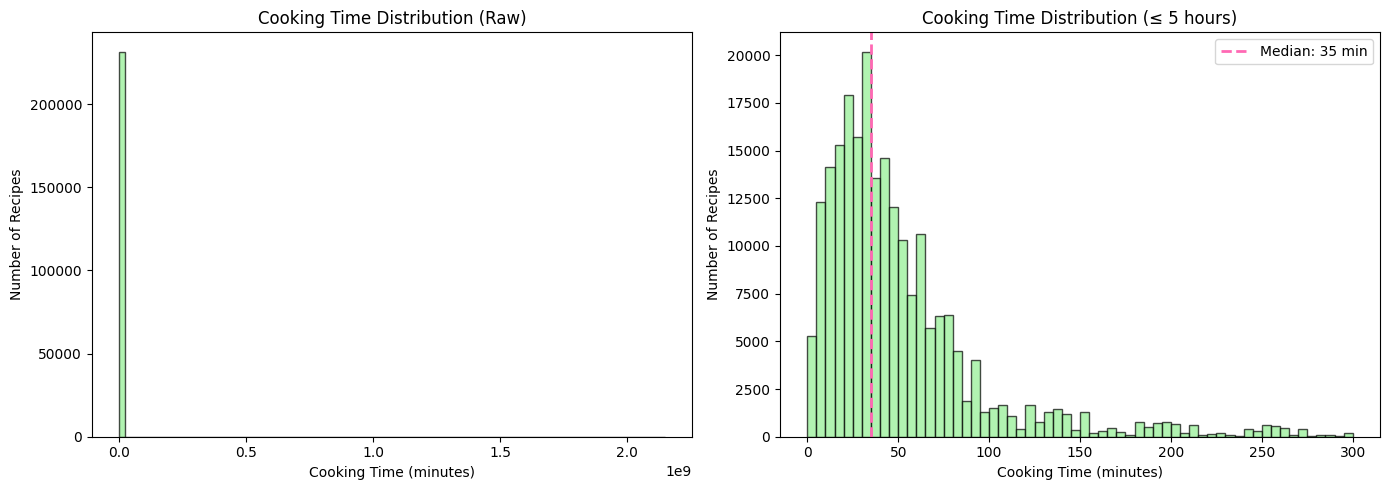

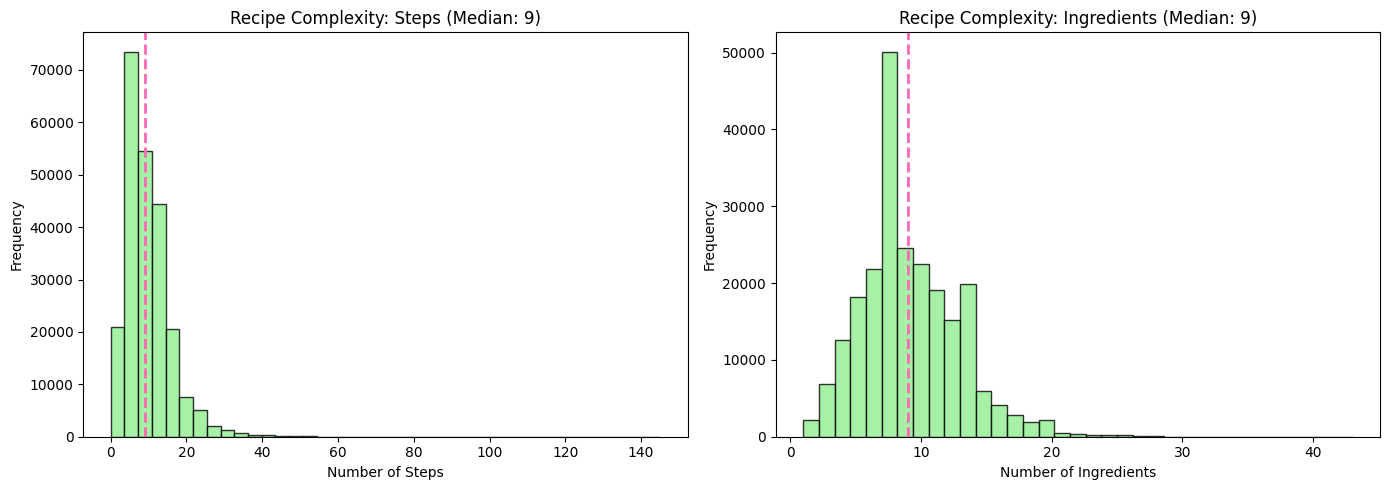

In [6]:
# RECIPE CHARACTERISTICS ANALYSIS

# Get unique recipes for analysis (avoid counting duplicates from reviews)
unique_recipes = merged_data.drop_duplicates(subset=["id"])
print(f"Unique recipes in dataset: {len(unique_recipes):,}")

# --- Cooking Time Analysis ---
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Raw distribution
axes[0].hist(unique_recipes["minutes"], bins=100, color="lightgreen", edgecolor="black", alpha=0.7)
axes[0].set_xlabel("Cooking Time (minutes)")
axes[0].set_ylabel("Number of Recipes")
axes[0].set_title("Cooking Time Distribution (Raw)")

# Identify and report outliers
time_stats = unique_recipes["minutes"].describe()
print("\nCooking time statistics:")
print(time_stats)

# Filtered distribution (remove extreme outliers for visualization)
reasonable_time = unique_recipes[unique_recipes["minutes"] <= 300]["minutes"]
axes[1].hist(reasonable_time, bins=60, color="lightgreen", edgecolor="black", alpha=0.7)
axes[1].axvline(reasonable_time.median(), color="hotpink", linestyle="--", linewidth=2, label=f"Median: {reasonable_time.median():.0f} min")
axes[1].set_xlabel("Cooking Time (minutes)")
axes[1].set_ylabel("Number of Recipes")
axes[1].set_title("Cooking Time Distribution (≤ 5 hours)")
axes[1].legend()

plt.tight_layout()
plt.show()

# --- Recipe Complexity ---
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Number of steps
axes[0].hist(unique_recipes["n_steps"], bins=40, color="lightgreen", edgecolor="black", alpha=0.8)
axes[0].axvline(unique_recipes["n_steps"].median(), color="hotpink", linestyle="--", linewidth=2)
axes[0].set_xlabel("Number of Steps")
axes[0].set_ylabel("Frequency")
axes[0].set_title(f"Recipe Complexity: Steps (Median: {unique_recipes['n_steps'].median():.0f})")

# Number of ingredients
axes[1].hist(unique_recipes["n_ingredients"], bins=35, color="lightgreen", edgecolor="black", alpha=0.8)
axes[1].axvline(unique_recipes["n_ingredients"].median(), color="hotpink", linestyle="--", linewidth=2)
axes[1].set_xlabel("Number of Ingredients")
axes[1].set_ylabel("Frequency")
axes[1].set_title(f"Recipe Complexity: Ingredients (Median: {unique_recipes['n_ingredients'].median():.0f})")

plt.tight_layout()
plt.show()

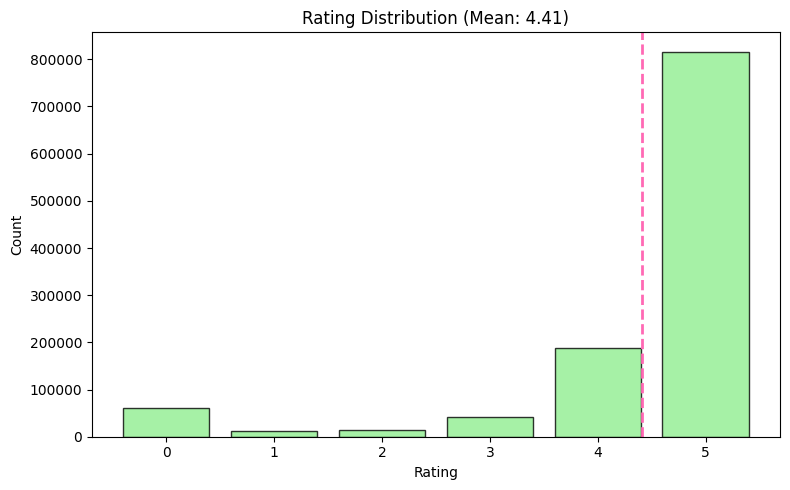

Rating statistics:
count    1.132367e+06
mean     4.411016e+00
std      1.264752e+00
min      0.000000e+00
25%      4.000000e+00
50%      5.000000e+00
75%      5.000000e+00
max      5.000000e+00
Name: rating, dtype: float64


In [7]:
# RATING ANALYSIS

# Rating distribution
fig, ax = plt.subplots(figsize=(8, 5))
rating_freq = merged_data["rating"].value_counts().sort_index()
bars = ax.bar(rating_freq.index, rating_freq.values, color="lightgreen", edgecolor="black", alpha=0.8)
ax.axvline(merged_data["rating"].mean(), color="hotpink", linestyle="--", linewidth=2)
ax.set_xlabel("Rating")
ax.set_ylabel("Count")
ax.set_title(f"Rating Distribution (Mean: {merged_data['rating'].mean():.2f})")
ax.set_xticks([0, 1, 2, 3, 4, 5])

plt.tight_layout()
plt.show()

print(f"Rating statistics:")
print(merged_data["rating"].describe())

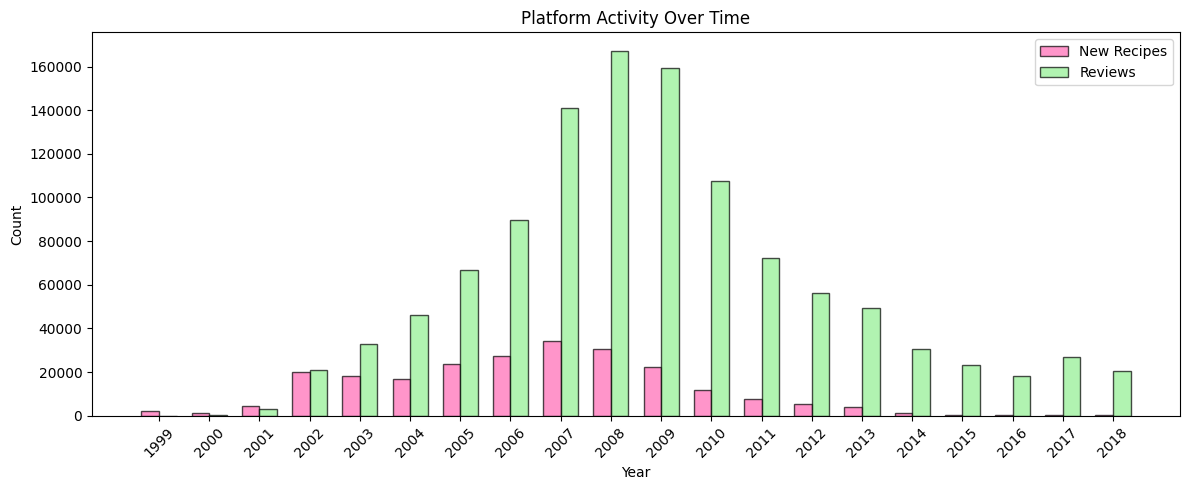

In [8]:
# TEMPORAL TRENDS

# Yearly activity
fig, ax = plt.subplots(figsize=(12, 5))

yearly_submissions = unique_recipes.groupby("recipe_year").size()
yearly_reviews = merged_data.groupby("review_year").size()

years = sorted(set(yearly_submissions.index.dropna()) | set(yearly_reviews.index.dropna()))
bar_width = 0.35
x_positions = np.arange(len(years))

ax.bar(x_positions - bar_width/2, [yearly_submissions.get(y, 0) for y in years], 
       bar_width, label="New Recipes", color="hotpink", edgecolor="black", alpha=0.7)
ax.bar(x_positions + bar_width/2, [yearly_reviews.get(y, 0) for y in years], 
       bar_width, label="Reviews", color="lightgreen", edgecolor="black", alpha=0.7)

ax.set_xticks(x_positions)
ax.set_xticklabels([int(y) if pd.notna(y) else "" for y in years], rotation=45)
ax.set_xlabel("Year")
ax.set_ylabel("Count")
ax.set_title("Platform Activity Over Time")
ax.legend()

plt.tight_layout()
plt.show()

Top 20 most common ingredients:
           ingredient  count
0                salt  85746
1              butter  54975
2               sugar  44535
3               onion  39065
4               water  34914
5                eggs  33761
6           olive oil  32822
7               flour  26266
8                milk  25786
9       garlic cloves  25748
10             pepper  22319
11        brown sugar  18655
12             garlic  18087
13  all-purpose flour  17659
14      baking powder  17504
15                egg  17304
16    salt and pepper  15415
17    parmesan cheese  14807
18        lemon juice  14233
19        baking soda  14099


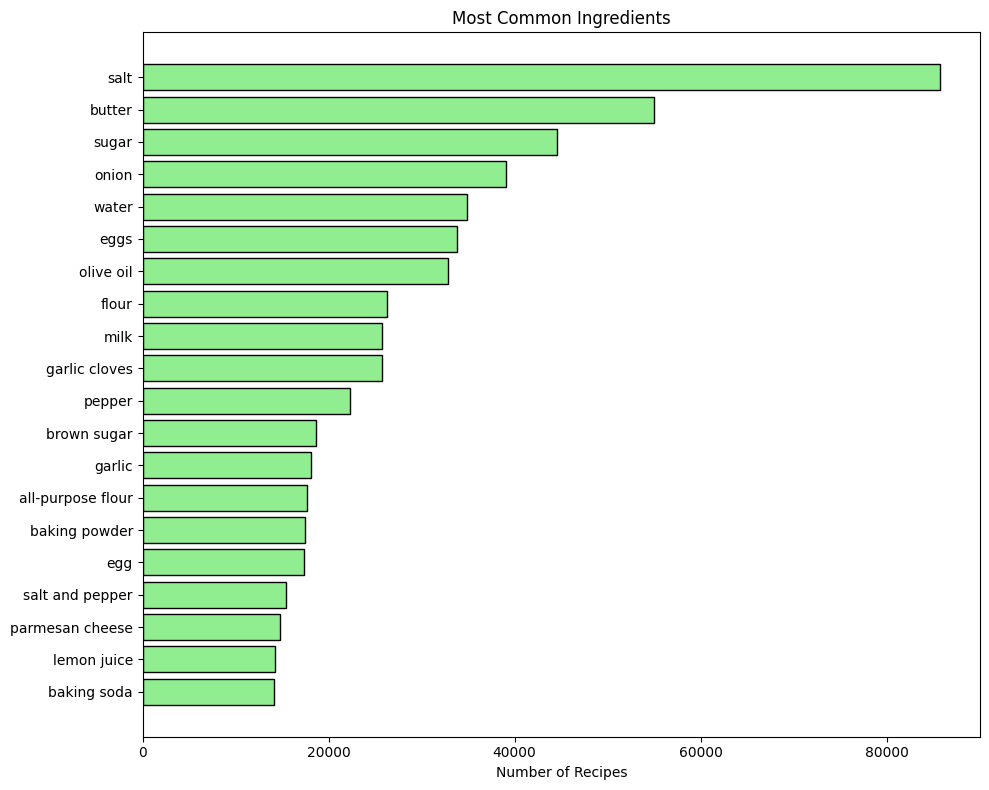

In [9]:
# INGREDIENT ANALYSIS (RELEVANT FOR SEARCH)

def extract_ingredients_list(ing_string):
    """Parse ingredient string into list"""
    try:
        cleaned = str(ing_string).replace("[", "").replace("]", "").replace("'", "")
        ingredients = [i.strip().lower() for i in cleaned.split(",")]
        return ingredients
    except:
        return []

# Extract all ingredients
all_ingredients = []
for ing_str in unique_recipes["ingredients"]:
    all_ingredients.extend(extract_ingredients_list(ing_str))

# Count frequency
ingredient_counts = Counter(all_ingredients)
top_ingredients = pd.DataFrame(
    ingredient_counts.most_common(20),
    columns=["ingredient", "count"]
)

print("Top 20 most common ingredients:")
print(top_ingredients)

# Visualization
fig, ax = plt.subplots(figsize=(10, 8))
ax.barh(top_ingredients["ingredient"][::-1], top_ingredients["count"][::-1], color="lightgreen", edgecolor="black")
ax.set_xlabel("Number of Recipes")
ax.set_title("Most Common Ingredients")

plt.tight_layout()
plt.show()

In [10]:
# TAG ANALYSIS (FOR SEMANTIC SEARCH)

def extract_tags_list(tag_string):
    """Parse tag string into list"""
    try:
        cleaned = str(tag_string).replace("[", "").replace("]", "").replace("'", "")
        tags = [t.strip().lower() for t in cleaned.split(",")]
        return tags
    except:
        return []

# Extract all tags
all_tags = []
for tag_str in unique_recipes["tags"]:
    all_tags.extend(extract_tags_list(tag_str))

# Count frequency
tag_counts = Counter(all_tags)
top_tags = pd.DataFrame(
    tag_counts.most_common(30),
    columns=["tag", "frequency"]
)

print("Top 30 most common tags:")
print(top_tags)

# These tags will be crucial for matching queries like "comfort food", "healthy", etc.
semantic_tags = ["comfort-food", "healthy", "quick", "easy", "romantic", "vegetarian", 
                 "low-carb", "dessert", "dinner", "lunch", "breakfast", "italian",
                 "mexican", "asian", "mediterranean", "summer", "winter", "holiday"]

print("\nSemantic tags present in dataset:")
for tag in semantic_tags:
    count = tag_counts.get(tag, 0)
    if count > 0:
        print(f"  {tag}: {count:,} recipes")


Top 30 most common tags:
                   tag  frequency
0          preparation     230546
1         time-to-make     225326
2               course     218148
3      main-ingredient     170446
4              dietary     165091
5                 easy     126062
6             occasion     114145
7              cuisine      91165
8     low-in-something      85776
9            main-dish      71786
10           equipment      70436
11  60-minutes-or-less      69990
12  number-of-servings      58949
13                meat      56042
14  30-minutes-or-less      55077
15          vegetables      53814
16          taste-mood      52143
17     4-hours-or-less      49497
18      north-american      48479
19     3-steps-or-less      44933
20  15-minutes-or-less      43934
21          low-sodium      43349
22            desserts      43203
23            low-carb      42189
24             healthy      40340
25        dinner-party      37561
26     low-cholesterol      36743
27         low-calorie 

In [11]:
# TEXT FIELD ANALYSIS

# Check text lengths in each field
text_fields = ["name", "description", "ingredients", "steps", "tags"]

for field in text_fields:
    if field in unique_recipes.columns:
        lengths = unique_recipes[field].astype(str).str.len()
        word_counts = unique_recipes[field].astype(str).str.split().str.len()
        null_count = unique_recipes[field].isnull().sum()
        print(f"\n{field.upper()}:")
        print(f"  Null values: {null_count} ({100*null_count/len(unique_recipes):.2f}%)")
        print(f"  Avg character length: {lengths.mean():.0f}")
        print(f"  Avg word count: {word_counts.mean():.1f}")



NAME:
  Null values: 1 (0.00%)
  Avg character length: 28
  Avg word count: 4.4

DESCRIPTION:
  Null values: 4979 (2.15%)
  Avg character length: 196
  Avg word count: 35.6

INGREDIENTS:
  Null values: 0 (0.00%)
  Avg character length: 139
  Avg word count: 16.5

STEPS:
  Null values: 0 (0.00%)
  Avg character length: 563
  Avg word count: 102.1

TAGS:
  Null values: 0 (0.00%)
  Avg character length: 255
  Avg word count: 17.9


# Preprocessing

In [12]:
# CORPUS CREATION FOR SEARCH ENGINE

# Create corpus dataframe with unique recipes
corpus = unique_recipes[["id", "name", "tags", "description", "ingredients", "steps"]].copy()

# Clean each text field using vectorized pandas operations (MUCH FASTER)
text_columns = ["name", "tags", "description", "ingredients", "steps"]

for col in text_columns:
    corpus[col + "_clean"] = (
        corpus[col]
        .fillna("")
        .astype(str)
        .str.replace("[", "", regex=False)
        .str.replace("]", "", regex=False)
        .str.replace("'", "", regex=False)
        .str.replace('"', "", regex=False)
        .str.lower()
        .str.replace(r"\s+", " ", regex=True)
        .str.strip()
    )
    print(f"  Cleaned: {col}")

# Combine all text into single document per recipe
corpus["document"] = (
    corpus["name_clean"] + " " +
    corpus["tags_clean"] + " " +
    corpus["description_clean"] + " " +
    corpus["ingredients_clean"] + " " +
    corpus["steps_clean"]
)

# Final cleaning
corpus["document"] = (
    corpus["document"]
    .str.replace(r"\s+", " ", regex=True)
    .str.strip()
)

# Remove recipes with empty documents
initial_count = len(corpus)
corpus = corpus[corpus["document"].str.len() > 10]
print(f"\nRemoved {initial_count - len(corpus)} recipes with insufficient text")

# Calculate document statistics
corpus["doc_length"] = corpus["document"].str.len()
corpus["word_count"] = corpus["document"].str.split().str.len()

print(f"\nFinal corpus size: {len(corpus):,} recipes")
print(f"\nDocument statistics:")
print(corpus[["doc_length", "word_count"]].describe().round(0))

# Preview sample documents
print("\n--- Sample Documents ---")
for idx in [0, 100, 500]:
    if idx < len(corpus):
        row = corpus.iloc[idx]
        print(f"\nRecipe: {row['name']}")
        print(f"Document preview: {row['document'][:300]}...")


  Cleaned: name
  Cleaned: tags
  Cleaned: description
  Cleaned: ingredients
  Cleaned: steps

Removed 0 recipes with insufficient text

Final corpus size: 231,637 recipes

Document statistics:
       doc_length  word_count
count    231637.0    231637.0
mean       1103.0       176.0
std         489.0        91.0
min         191.0        24.0
25%         777.0       116.0
50%        1005.0       157.0
75%        1312.0       214.0
max       12357.0      2354.0

--- Sample Documents ---

Recipe: arriba   baked winter squash mexican style
Document preview: arriba baked winter squash mexican style 60-minutes-or-less, time-to-make, course, main-ingredient, cuisine, preparation, occasion, north-american, side-dishes, vegetables, mexican, easy, fall, holiday-event, vegetarian, winter, dietary, christmas, seasonal, squash autumn is my favorite time of year...

Recipe: tide me over   indian chaat  simple veggie salad
Document preview: tide me over indian chaat simple veggie salad 15-minutes-or

In [ ]:
# EXPORT CORPUS

# Save full corpus with metadata
corpus_export = corpus[["id", "name", "tags_clean", "document", "word_count"]].copy()
corpus_export.columns = ["recipe_id", "recipe_name", "tags", "document", "word_count"]
corpus_export.to_csv("search_corpus.csv", index=False)
print(f"Saved corpus to 'search_corpus.csv'")

# Save recipe metadata for displaying search results
metadata = unique_recipes[["id", "name", "minutes", "n_ingredients", "n_steps", "description"]].copy()
metadata.columns = ["recipe_id", "recipe_name", "cooking_time", "num_ingredients", "num_steps", "description"]
metadata.to_csv("recipe_metadata.csv", index=False)
print(f"Saved metadata to 'recipe_metadata.csv'")

Saved corpus to 'search_corpus.csv'
Saved metadata to 'recipe_metadata.csv'


In [ ]:
# CORPUS QUALITY CHECK

# Verify key terms exist for semantic queries
test_queries = [
    "comfort food",
    "healthy dinner",
    "quick breakfast",
    "romantic dinner",
    "vegetarian lunch",
    "low carb",
    "summer dessert",
    "holiday cookies"
]

print("Checking corpus coverage for potential search queries:\n")
for query in test_queries:
    query_terms = query.lower().split()
    
    # Vectorized approach: check each term separately then combine
    mask = pd.Series([True] * len(corpus), index=corpus.index)
    for term in query_terms:
        mask = mask & corpus["document"].str.contains(term, regex=False)
    
    matches = mask.sum()
    print(f"  '{query}': {matches:,} potential matches")

Checking corpus coverage for potential search queries:

  'comfort food': 27,504 potential matches
  'healthy dinner': 8,262 potential matches
  'quick breakfast': 3,415 potential matches
  'romantic dinner': 3,669 potential matches
  'vegetarian lunch': 5,698 potential matches
  'low carb': 44,128 potential matches
  'summer dessert': 2,924 potential matches
  'holiday cookies': 4,286 potential matches


# TF-IDF Search Engine

In [15]:
# LOAD CORPUS
corpus_df = pd.read_csv("search_corpus.csv")
metadata_df = pd.read_csv("recipe_metadata.csv")

print(f"    Loaded {len(corpus_df):,} recipes")
print(f"    Sample document length: {corpus_df['word_count'].mean():.0f} words (avg)")

# TEXT PREPROCESSING CLASS
class TextPreprocessor:
    """
    Advanced text preprocessor for recipe documents.
    Handles tokenization, stopword removal, and lemmatization.
    """
    
    def __init__(self, 
                 remove_stopwords=True, 
                 use_lemmatization=True,
                 use_stemming=False,
                 min_word_length=2,
                 custom_stopwords=None):
        """
        Initialize preprocessor with configuration options.
        
        Args:
            remove_stopwords: Whether to remove English stopwords
            use_lemmatization: Whether to apply lemmatization
            use_stemming: Whether to apply stemming (alternative to lemmatization)
            min_word_length: Minimum word length to keep
            custom_stopwords: Additional domain-specific stopwords
        """
        self.remove_stopwords = remove_stopwords
        self.use_lemmatization = use_lemmatization
        self.use_stemming = use_stemming
        self.min_word_length = min_word_length
        
        # Initialize NLTK tools
        self.lemmatizer = WordNetLemmatizer() if use_lemmatization else None
        self.stemmer = PorterStemmer() if use_stemming else None
        
        # Build stopword set
        self.stopwords = set(stopwords.words('english')) if remove_stopwords else set()
        
        # Add recipe-specific stopwords (common but non-informative terms)
        recipe_stopwords = {
            'cup', 'cups', 'tablespoon', 'tablespoons', 'teaspoon', 'teaspoons',
            'tbsp', 'tsp', 'oz', 'ounce', 'ounces', 'pound', 'pounds', 'lb', 'lbs',
            'inch', 'inches', 'minute', 'minutes', 'hour', 'hours',
            'medium', 'large', 'small', 'fresh', 'chopped', 'minced', 'diced',
            'add', 'place', 'put', 'make', 'use', 'take', 'get', 'set',
            'recipe', 'recipes', 'ingredient', 'ingredients', 'step', 'steps',
            'one', 'two', 'three', 'four', 'five', 'six', 'time', 'preparation'
        }
        self.stopwords.update(recipe_stopwords)
        
        # Add custom stopwords if provided
        if custom_stopwords:
            self.stopwords.update(custom_stopwords)
    
    def preprocess(self, text):
        """
        Full preprocessing pipeline for a single document.
        
        Args:
            text: Raw text string
            
        Returns:
            Preprocessed text string
        """
        if pd.isna(text) or not isinstance(text, str):
            return ""
        
        # Convert to lowercase
        text = text.lower()
        
        # Remove special characters and digits (keep letters and spaces)
        text = re.sub(r'[^a-zA-Z\s]', ' ', text)
        
        # Tokenize
        tokens = word_tokenize(text)
        
        # Process tokens
        processed_tokens = []
        for token in tokens:
            # Skip short words
            if len(token) < self.min_word_length:
                continue
            
            # Skip stopwords
            if self.remove_stopwords and token in self.stopwords:
                continue
            
            # Apply lemmatization or stemming
            if self.use_lemmatization and self.lemmatizer:
                token = self.lemmatizer.lemmatize(token, pos='v')  # Verb lemmatization
                token = self.lemmatizer.lemmatize(token, pos='n')  # Noun lemmatization
            elif self.use_stemming and self.stemmer:
                token = self.stemmer.stem(token)
            
            processed_tokens.append(token)
        
        return ' '.join(processed_tokens)
    
    def preprocess_batch(self, texts, show_progress=True):
        """
        Preprocess a batch of documents.
        
        Args:
            texts: Iterable of text strings
            show_progress: Whether to show progress updates
            
        Returns:
            List of preprocessed text strings
        """
        processed = []
        total = len(texts)
        
        for i, text in enumerate(texts):
            processed.append(self.preprocess(text))
            
            if show_progress and (i + 1) % 50000 == 0:
                print(f"        Processed {i+1:,}/{total:,} documents...")
        
        return processed


# TF-IDF SEARCH ENGINE CLASS
class TFIDFSearchEngine:
    """
    TF-IDF based recipe search engine.
    Supports both unigrams and n-grams for better phrase matching.
    """
    
    def __init__(self, 
                 ngram_range=(1, 2),
                 max_features=50000,
                 min_df=2,
                 max_df=0.95,
                 sublinear_tf=True):
        """
        Initialize the TF-IDF search engine.
        
        Args:
            ngram_range: Tuple (min_n, max_n) for n-gram range
            max_features: Maximum number of features in vocabulary
            min_df: Minimum document frequency for terms
            max_df: Maximum document frequency for terms (filters very common words)
            sublinear_tf: Apply sublinear TF scaling (1 + log(tf))
        """
        self.ngram_range = ngram_range
        self.max_features = max_features
        
        # Initialize TF-IDF Vectorizer
        self.vectorizer = TfidfVectorizer(
            ngram_range=ngram_range,
            max_features=max_features,
            min_df=min_df,
            max_df=max_df,
            sublinear_tf=sublinear_tf,
            dtype=np.float32  # Use float32 to save memory
        )
        
        # Initialize preprocessor
        self.preprocessor = TextPreprocessor(
            remove_stopwords=True,
            use_lemmatization=True,
            use_stemming=False
        )
        
        # Storage for fitted data
        self.tfidf_matrix = None
        self.document_ids = None
        self.is_fitted = False
        
    def fit(self, documents, document_ids=None, preprocess=True):
        """
        Fit the TF-IDF model on a corpus of documents.
        
        Args:
            documents: List or Series of document strings
            document_ids: Optional list of document identifiers
            preprocess: Whether to apply text preprocessing
        """
        print("    Fitting TF-IDF model...")
        
        # Store document IDs
        if document_ids is not None:
            self.document_ids = list(document_ids)
        else:
            self.document_ids = list(range(len(documents)))
        
        # Preprocess documents if requested
        if preprocess:
            print("    Preprocessing documents...")
            processed_docs = self.preprocessor.preprocess_batch(documents)
        else:
            processed_docs = list(documents)
        
        # Fit and transform TF-IDF
        print("    Computing TF-IDF matrix...")
        self.tfidf_matrix = self.vectorizer.fit_transform(processed_docs)
        
        self.is_fitted = True
        
        # Report statistics
        vocab_size = len(self.vectorizer.vocabulary_)
        n_docs = self.tfidf_matrix.shape[0]
        sparsity = 1.0 - (self.tfidf_matrix.nnz / (n_docs * vocab_size))
        
        print(f"\n    TF-IDF Model Statistics:")
        print(f"        Documents: {n_docs:,}")
        print(f"        Vocabulary size: {vocab_size:,}")
        print(f"        N-gram range: {self.ngram_range}")
        print(f"        Matrix shape: {self.tfidf_matrix.shape}")
        print(f"        Matrix sparsity: {sparsity:.2%}")
        print(f"        Non-zero elements: {self.tfidf_matrix.nnz:,}")
        
    def search(self, query, top_k=10, preprocess=True):
        """
        Search for recipes matching a query.
        
        Args:
            query: Search query string
            top_k: Number of results to return
            preprocess: Whether to preprocess the query
            
        Returns:
            List of tuples (document_id, similarity_score)
        """
        if not self.is_fitted:
            raise ValueError("Model not fitted. Call fit() first.")
        
        # Preprocess query
        if preprocess:
            processed_query = self.preprocessor.preprocess(query)
        else:
            processed_query = query
        
        # Transform query to TF-IDF vector
        query_vector = self.vectorizer.transform([processed_query])
        
        # Compute cosine similarities
        similarities = cosine_similarity(query_vector, self.tfidf_matrix).flatten()
        
        # Get top-k results
        top_indices = np.argsort(similarities)[::-1][:top_k]
        
        results = []
        for idx in top_indices:
            doc_id = self.document_ids[idx]
            score = similarities[idx]
            results.append((doc_id, score))
        
        return results
    
    def get_query_terms(self, query, preprocess=True):
        """
        Get the terms from a query that exist in the vocabulary.
        Useful for understanding what the model is matching.
        
        Args:
            query: Search query string
            preprocess: Whether to preprocess the query
            
        Returns:
            Dictionary with matched and unmatched terms
        """
        if preprocess:
            processed_query = self.preprocessor.preprocess(query)
        else:
            processed_query = query
        
        query_terms = processed_query.split()
        vocabulary = set(self.vectorizer.vocabulary_.keys())
        
        matched = [t for t in query_terms if t in vocabulary]
        unmatched = [t for t in query_terms if t not in vocabulary]
        
        # Also check for n-grams
        matched_ngrams = []
        for n in range(2, self.ngram_range[1] + 1):
            for i in range(len(query_terms) - n + 1):
                ngram = ' '.join(query_terms[i:i+n])
                if ngram in vocabulary:
                    matched_ngrams.append(ngram)
        
        return {
            'original_query': query,
            'processed_query': processed_query,
            'matched_terms': matched,
            'matched_ngrams': matched_ngrams,
            'unmatched_terms': unmatched
        }
    
    def get_top_terms_for_document(self, doc_idx, top_k=10):
        """
        Get the highest weighted TF-IDF terms for a document.
        
        Args:
            doc_idx: Index of document in corpus
            top_k: Number of terms to return
            
        Returns:
            List of tuples (term, tfidf_weight)
        """
        feature_names = self.vectorizer.get_feature_names_out()
        doc_vector = self.tfidf_matrix[doc_idx].toarray().flatten()
        
        top_indices = np.argsort(doc_vector)[::-1][:top_k]
        
        return [(feature_names[i], doc_vector[i]) for i in top_indices if doc_vector[i] > 0]
    
    def save(self, filepath):
        """Save the fitted model to disk."""
        with open(filepath, 'wb') as f:
            pickle.dump({
                'vectorizer': self.vectorizer,
                'tfidf_matrix': self.tfidf_matrix,
                'document_ids': self.document_ids,
                'preprocessor': self.preprocessor,
                'ngram_range': self.ngram_range,
                'max_features': self.max_features
            }, f)
        print(f"    Model saved to {filepath}")
    
    def load(self, filepath):
        """Load a fitted model from disk."""
        with open(filepath, 'rb') as f:
            data = pickle.load(f)
        
        self.vectorizer = data['vectorizer']
        self.tfidf_matrix = data['tfidf_matrix']
        self.document_ids = data['document_ids']
        self.preprocessor = data['preprocessor']
        self.ngram_range = data['ngram_range']
        self.max_features = data['max_features']
        self.is_fitted = True
        
        print(f"    Model loaded from {filepath}")


# UTILITY FUNCTIONS FOR DISPLAYING RESULTS
def display_search_results(results, metadata_df, corpus_df, query, show_snippet=True):
    """
    Display search results in a formatted way.
    
    Args:
        results: List of (recipe_id, score) tuples
        metadata_df: DataFrame with recipe metadata
        corpus_df: DataFrame with corpus documents
        query: The search query (for display)
        show_snippet: Whether to show document snippets
    """
    print(f"\n{'='*70}")
    print(f"SEARCH RESULTS FOR: '{query}'")
    print(f"{'='*70}")
    
    for rank, (recipe_id, score) in enumerate(results, 1):
        # Get metadata
        meta_row = metadata_df[metadata_df['recipe_id'] == recipe_id]
        corpus_row = corpus_df[corpus_df['recipe_id'] == recipe_id]
        
        if len(meta_row) == 0:
            continue
            
        meta = meta_row.iloc[0]
        
        print(f"\n[{rank}] {meta['recipe_name']}")
        print(f"    Score: {score:.4f}")
        print(f"    Cooking Time: {meta['cooking_time']} min | "
              f"Ingredients: {meta['num_ingredients']} | "
              f"Steps: {meta['num_steps']}")
        
        if show_snippet and len(corpus_row) > 0:
            doc = corpus_row.iloc[0]['document']
            # Show first 200 characters
            snippet = doc[:200] + "..." if len(doc) > 200 else doc
            print(f"    Preview: {snippet}")
        
        # Show description if available
        if pd.notna(meta['description']) and str(meta['description']) != 'nan':
            desc = str(meta['description'])[:150]
            print(f"    Description: {desc}...")


def analyze_query_matching(search_engine, query):
    """
    Analyze how a query is being matched by the TF-IDF model.
    """
    analysis = search_engine.get_query_terms(query)
    
    print(f"\n--- Query Analysis for: '{query}' ---")
    print(f"Processed query: '{analysis['processed_query']}'")
    print(f"Matched unigrams: {analysis['matched_terms']}")
    print(f"Matched n-grams: {analysis['matched_ngrams']}")
    print(f"Unmatched terms: {analysis['unmatched_terms']}")


# BUILD AND TEST THE SEARCH ENGINE
# Initialize search engine with bigrams (1-grams and 2-grams)
tfidf_engine = TFIDFSearchEngine(
    ngram_range=(1, 2),      # Unigrams and bigrams
    max_features=50000,       # Vocabulary size limit
    min_df=3,                 # Term must appear in at least 3 documents
    max_df=0.90,              # Term can appear in max 90% of documents
    sublinear_tf=True         # Use logarithmic TF scaling
)

# Fit on corpus
tfidf_engine.fit(
    documents=corpus_df['document'],
    document_ids=corpus_df['recipe_id'],
    preprocess=True
)

# Save the model for later use
tfidf_engine.save("tfidf_search_engine.pkl")


# TEST QUERIES
# Define test queries (mix of simple and semantic)
test_queries = [
    # Simple keyword queries
    "chocolate cake",
    "pasta carbonara",
    "chicken soup",
    
    # Semantic/high-level queries (these are the challenging ones!)
    "comfort food for a rainy day",
    "healthy dinner after gym",
    "quick and easy breakfast",
    "romantic dinner for two",
    "light summer salad",
    "warm winter soup",
    "kid friendly lunch",
    "low carb vegetarian"
]

# Run searches
for query in test_queries:
    # Analyze query matching
    analyze_query_matching(tfidf_engine, query)
    
    # Get search results
    results = tfidf_engine.search(query, top_k=5)
    
    # Display results
    display_search_results(results, metadata_df, corpus_df, query, show_snippet=False)
    
    print("\n" + "-" * 70)


# VOCABULARY ANALYSIS
# Get vocabulary
vocab = tfidf_engine.vectorizer.vocabulary_
feature_names = tfidf_engine.vectorizer.get_feature_names_out()

print(f"\nTotal vocabulary size: {len(vocab):,}")

# Check for semantic terms
semantic_terms = [
    "comfort", "healthy", "quick", "easy", "romantic", "light",
    "summer", "winter", "warm", "cozy", "fresh", "hearty",
    "kid", "family", "dinner", "breakfast", "lunch", "dessert",
    "vegetarian", "vegan", "low carb", "gluten free"
]

print("\nSemantic terms in vocabulary:")
for term in semantic_terms:
    if term in vocab:
        print(f"  ✓ '{term}' (index: {vocab[term]})")
    else:
        print(f"  ✗ '{term}' NOT FOUND")

# Find bigrams in vocabulary
print("\nSample bigrams in vocabulary:")
bigrams = [term for term in feature_names if ' ' in term][:20]
for bg in bigrams:
    print(f"  - {bg}")


# EXPORT TEST RESULTS FOR COMPARISON
# Save search results for later comparison with embeddings
tfidf_results = {}

comparison_queries = [
    "comfort food for a rainy day",
    "healthy dinner after gym",
    "quick and easy breakfast",
    "romantic dinner for two",
    "light summer salad",
    "vegetarian protein rich",
    "decadent chocolate dessert",
    "mediterranean diet lunch"
]

for query in comparison_queries:
    results = tfidf_engine.search(query, top_k=20)
    tfidf_results[query] = results

    Loaded 231,637 recipes
    Sample document length: 176 words (avg)
    Fitting TF-IDF model...
    Preprocessing documents...
        Processed 50,000/231,637 documents...
        Processed 100,000/231,637 documents...
        Processed 150,000/231,637 documents...
        Processed 200,000/231,637 documents...
    Computing TF-IDF matrix...

    TF-IDF Model Statistics:
        Documents: 231,637
        Vocabulary size: 50,000
        N-gram range: (1, 2)
        Matrix shape: (231637, 50000)
        Matrix sparsity: 99.72%
        Non-zero elements: 32,650,031
    Model saved to tfidf_search_engine.pkl

--- Query Analysis for: 'chocolate cake' ---
Processed query: 'chocolate cake'
Matched unigrams: ['chocolate', 'cake']
Matched n-grams: ['chocolate cake']
Unmatched terms: []

SEARCH RESULTS FOR: 'chocolate cake'

[1] store bought chocolate cake and milk
    Score: 0.3677
    Cooking Time: 5 min | Ingredients: 2 | Steps: 4
    Description: this is a recipe that my friend's dad wo

# Neural Embeddings Search Engine

In [16]:
# Optional: FAISS for faster similarity search on large datasets
try:
    import faiss
    FAISS_AVAILABLE = True
except ImportError:
    FAISS_AVAILABLE = False
    print("Note: FAISS not installed. Using sklearn for similarity search.")


# Check for GPU availability
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using device: {device}")
if device == "cuda":
    print(f"GPU: {torch.cuda.get_device_name(0)}")


# LOAD CORPUS
corpus_df = pd.read_csv("search_corpus.csv")
metadata_df = pd.read_csv("recipe_metadata.csv")

print(f"    Loaded {len(corpus_df):,} recipes")


# DOCUMENT PREPARATION FOR EMBEDDINGS
class DocumentPreparer:
    """
    Prepares recipe documents for embedding.
    Different from TF-IDF preprocessing - we want to preserve semantic meaning.
    """
    
    def __init__(self, max_length=512):
        """
        Args:
            max_length: Maximum document length (in words) to prevent 
                       truncation issues with transformer models
        """
        self.max_length = max_length
    
    def prepare_document(self, row):
        """
        Create an optimized document representation for embedding.
        We structure it to emphasize searchable attributes.
        
        Args:
            row: DataFrame row with recipe data
            
        Returns:
            Formatted document string
        """
        parts = []
        
        # Recipe name (most important - repeat for emphasis)
        if pd.notna(row.get('recipe_name', '')):
            name = str(row['recipe_name']).strip()
            parts.append(f"Recipe: {name}")
        
        # Tags (crucial for semantic matching)
        if pd.notna(row.get('tags', '')):
            tags = str(row['tags']).strip()
            # Clean and format tags
            tags_clean = tags.replace(',', ', ')
            parts.append(f"Tags: {tags_clean}")
        
        # Get full document and truncate if needed
        if pd.notna(row.get('document', '')):
            doc = str(row['document']).strip()
            words = doc.split()
            if len(words) > self.max_length:
                doc = ' '.join(words[:self.max_length])
            parts.append(doc)
        
        return ' '.join(parts)
    
    def prepare_batch(self, df):
        """
        Prepare a batch of documents.
        
        Args:
            df: DataFrame with recipe data
            
        Returns:
            List of prepared document strings
        """
        prepared = []
        for idx, row in tqdm(df.iterrows(), total=len(df), desc="Preparing documents"):
            prepared.append(self.prepare_document(row))
        return prepared


# EMBEDDINGS SEARCH ENGINE CLASS
class EmbeddingsSearchEngine:
    """
    Neural embeddings-based recipe search engine using Sentence Transformers.
    Captures semantic meaning of queries and documents.
    """
    
    # Available models (from smaller/faster to larger/better)
    AVAILABLE_MODELS = {
        'mini': 'all-MiniLM-L6-v2',           # 80MB, fast, good quality
        'mpnet': 'all-mpnet-base-v2',          # 420MB, best quality
        'distilbert': 'all-distilroberta-v1',  # 290MB, good balance
        'minilm-l12': 'all-MiniLM-L12-v2',     # 120MB, better than L6
        'multi': 'paraphrase-multilingual-MiniLM-L12-v2'  # Multilingual
    }
    
    def __init__(self, model_name='mini', use_faiss=True, batch_size=64):
        """
        Initialize the embeddings search engine.
        
        Args:
            model_name: Key from AVAILABLE_MODELS or full HuggingFace model name
            use_faiss: Whether to use FAISS for fast similarity search
            batch_size: Batch size for encoding documents
        """
        # Resolve model name
        if model_name in self.AVAILABLE_MODELS:
            self.model_path = self.AVAILABLE_MODELS[model_name]
        else:
            self.model_path = model_name
        
        self.batch_size = batch_size
        self.use_faiss = use_faiss and FAISS_AVAILABLE
        
        # Load the sentence transformer model
        print(f"    Loading model: {self.model_path}")
        self.model = SentenceTransformer(self.model_path, device=device)
        
        # Get embedding dimension
        self.embedding_dim = self.model.get_sentence_embedding_dimension()
        print(f"    Embedding dimension: {self.embedding_dim}")
        
        # Storage
        self.embeddings = None
        self.document_ids = None
        self.faiss_index = None
        self.is_fitted = False
        
        # Document preparer
        self.doc_preparer = DocumentPreparer(max_length=256)
    
    def fit(self, documents, document_ids=None, show_progress=True):
        """
        Compute embeddings for all documents in the corpus.
        
        Args:
            documents: List or Series of document strings (or DataFrame)
            document_ids: Optional list of document identifiers
            show_progress: Whether to show progress bar
        """
        print("\n    Computing document embeddings...")
        
        # Handle DataFrame input
        if isinstance(documents, pd.DataFrame):
            print("    Preparing documents from DataFrame...")
            doc_list = self.doc_preparer.prepare_batch(documents)
            if document_ids is None and 'recipe_id' in documents.columns:
                document_ids = documents['recipe_id'].tolist()
        else:
            doc_list = list(documents)
        
        # Store document IDs
        if document_ids is not None:
            self.document_ids = list(document_ids)
        else:
            self.document_ids = list(range(len(doc_list)))
        
        # Compute embeddings in batches
        print(f"    Encoding {len(doc_list):,} documents...")
        self.embeddings = self.model.encode(
            doc_list,
            batch_size=self.batch_size,
            show_progress_bar=show_progress,
            convert_to_numpy=True,
            normalize_embeddings=True  # L2 normalize for cosine similarity
        )
        
        print(f"    Embeddings shape: {self.embeddings.shape}")
        
        # Build FAISS index for fast search
        if self.use_faiss:
            self._build_faiss_index()
        
        self.is_fitted = True
        
        # Report statistics
        print(f"\n    Embeddings Search Engine Statistics:")
        print(f"        Documents: {len(self.document_ids):,}")
        print(f"        Embedding dimension: {self.embedding_dim}")
        print(f"        Total memory: {self.embeddings.nbytes / 1024**2:.1f} MB")
        print(f"        Using FAISS: {self.use_faiss}")
    
    def _build_faiss_index(self):
        """Build FAISS index for fast approximate nearest neighbor search."""
        print("    Building FAISS index...")
        
        # Use Inner Product index (equivalent to cosine similarity for normalized vectors)
        self.faiss_index = faiss.IndexFlatIP(self.embedding_dim)
        
        # Add vectors to index
        self.faiss_index.add(self.embeddings.astype(np.float32))
        
        print(f"    FAISS index built with {self.faiss_index.ntotal} vectors")
    
    def encode_query(self, query):
        """
        Encode a query string into an embedding vector.
        
        Args:
            query: Query string
            
        Returns:
            Normalized embedding vector
        """
        embedding = self.model.encode(
            query,
            convert_to_numpy=True,
            normalize_embeddings=True
        )
        return embedding
    
    def search(self, query, top_k=10):
        """
        Search for recipes matching a query using semantic similarity.
        
        Args:
            query: Search query string
            top_k: Number of results to return
            
        Returns:
            List of tuples (document_id, similarity_score)
        """
        if not self.is_fitted:
            raise ValueError("Model not fitted. Call fit() first.")
        
        # Encode query
        query_embedding = self.encode_query(query)
        
        if self.use_faiss:
            # FAISS search
            query_embedding = query_embedding.reshape(1, -1).astype(np.float32)
            scores, indices = self.faiss_index.search(query_embedding, top_k)
            
            results = []
            for idx, score in zip(indices[0], scores[0]):
                if idx != -1:  # FAISS returns -1 for empty results
                    doc_id = self.document_ids[idx]
                    results.append((doc_id, float(score)))
        else:
            # Sklearn cosine similarity
            query_embedding = query_embedding.reshape(1, -1)
            similarities = cosine_similarity(query_embedding, self.embeddings).flatten()
            
            # Get top-k results
            top_indices = np.argsort(similarities)[::-1][:top_k]
            
            results = []
            for idx in top_indices:
                doc_id = self.document_ids[idx]
                score = similarities[idx]
                results.append((doc_id, float(score)))
        
        return results
    
    def search_batch(self, queries, top_k=10):
        """
        Search for multiple queries at once (more efficient).
        
        Args:
            queries: List of query strings
            top_k: Number of results per query
            
        Returns:
            Dictionary mapping queries to their results
        """
        # Encode all queries
        query_embeddings = self.model.encode(
            queries,
            batch_size=self.batch_size,
            convert_to_numpy=True,
            normalize_embeddings=True
        )
        
        results = {}
        
        if self.use_faiss:
            scores, indices = self.faiss_index.search(
                query_embeddings.astype(np.float32), top_k
            )
            
            for i, query in enumerate(queries):
                query_results = []
                for idx, score in zip(indices[i], scores[i]):
                    if idx != -1:
                        doc_id = self.document_ids[idx]
                        query_results.append((doc_id, float(score)))
                results[query] = query_results
        else:
            similarities = cosine_similarity(query_embeddings, self.embeddings)
            
            for i, query in enumerate(queries):
                top_indices = np.argsort(similarities[i])[::-1][:top_k]
                query_results = [
                    (self.document_ids[idx], float(similarities[i][idx]))
                    for idx in top_indices
                ]
                results[query] = query_results
        
        return results
    
    def get_similar_recipes(self, recipe_id, top_k=10):
        """
        Find recipes similar to a given recipe.
        
        Args:
            recipe_id: ID of the recipe to find similar items for
            top_k: Number of similar recipes to return
            
        Returns:
            List of tuples (recipe_id, similarity_score)
        """
        if recipe_id not in self.document_ids:
            raise ValueError(f"Recipe ID {recipe_id} not found in index")
        
        idx = self.document_ids.index(recipe_id)
        recipe_embedding = self.embeddings[idx].reshape(1, -1)
        
        if self.use_faiss:
            scores, indices = self.faiss_index.search(
                recipe_embedding.astype(np.float32), top_k + 1
            )
            # Skip the first result (the recipe itself)
            results = [
                (self.document_ids[i], float(s))
                for i, s in zip(indices[0][1:], scores[0][1:])
                if i != -1
            ]
        else:
            similarities = cosine_similarity(recipe_embedding, self.embeddings).flatten()
            top_indices = np.argsort(similarities)[::-1][1:top_k + 1]
            results = [
                (self.document_ids[i], float(similarities[i]))
                for i in top_indices
            ]
        
        return results
    
    def compute_query_document_similarity(self, query, recipe_id):
        """
        Compute similarity between a query and a specific recipe.
        
        Args:
            query: Query string
            recipe_id: ID of the recipe
            
        Returns:
            Similarity score
        """
        query_embedding = self.encode_query(query).reshape(1, -1)
        
        idx = self.document_ids.index(recipe_id)
        doc_embedding = self.embeddings[idx].reshape(1, -1)
        
        similarity = cosine_similarity(query_embedding, doc_embedding)[0][0]
        return float(similarity)
    
    def save(self, filepath):
        """Save the fitted model data to disk (not the transformer model itself)."""
        with open(filepath, 'wb') as f:
            pickle.dump({
                'embeddings': self.embeddings,
                'document_ids': self.document_ids,
                'model_path': self.model_path,
                'embedding_dim': self.embedding_dim
            }, f)
        print(f"    Embeddings saved to {filepath}")
    
    def load(self, filepath):
        """Load embeddings from disk."""
        with open(filepath, 'rb') as f:
            data = pickle.load(f)
        
        self.embeddings = data['embeddings']
        self.document_ids = data['document_ids']
        self.embedding_dim = data['embedding_dim']
        
        # Rebuild FAISS index
        if self.use_faiss:
            self._build_faiss_index()
        
        self.is_fitted = True
        print(f"    Embeddings loaded from {filepath}")


# UTILITY FUNCTIONS FOR DISPLAYING RESULTS
def display_search_results(results, metadata_df, corpus_df, query, engine_name=""):
    """
    Display search results in a formatted way.
    """
    print(f"\n{'='*70}")
    print(f"{engine_name} RESULTS FOR: '{query}'")
    print(f"{'='*70}")
    
    for rank, (recipe_id, score) in enumerate(results, 1):
        meta_row = metadata_df[metadata_df['recipe_id'] == recipe_id]
        
        if len(meta_row) == 0:
            continue
            
        meta = meta_row.iloc[0]
        
        print(f"\n[{rank}] {meta['recipe_name']}")
        print(f"    Similarity Score: {score:.4f}")
        print(f"    Cooking Time: {meta['cooking_time']} min | "
              f"Ingredients: {meta['num_ingredients']} | "
              f"Steps: {meta['num_steps']}")
        
        # Show tags if available
        corpus_row = corpus_df[corpus_df['recipe_id'] == recipe_id]
        if len(corpus_row) > 0:
            tags = corpus_row.iloc[0].get('tags', '')
            if pd.notna(tags) and str(tags) != 'nan':
                tags_preview = str(tags)[:100]
                print(f"    Tags: {tags_preview}...")
        
        # Show description
        if pd.notna(meta['description']) and str(meta['description']) != 'nan':
            desc = str(meta['description'])[:150]
            print(f"    Description: {desc}...")


def display_comparison(query, tfidf_results, embed_results, metadata_df):
    """
    Display side-by-side comparison of TF-IDF and Embeddings results.
    """
    print(f"\n{'='*70}")
    print(f"COMPARISON FOR: '{query}'")
    print(f"{'='*70}")
    
    print(f"\n{'TF-IDF Results':<35} | {'Embeddings Results':<35}")
    print("-" * 70)
    
    max_results = max(len(tfidf_results), len(embed_results))
    
    for i in range(min(max_results, 10)):
        # TF-IDF result
        if i < len(tfidf_results):
            tfidf_id, tfidf_score = tfidf_results[i]
            tfidf_meta = metadata_df[metadata_df['recipe_id'] == tfidf_id]
            if len(tfidf_meta) > 0:
                tfidf_name = str(tfidf_meta.iloc[0]['recipe_name'])[:30]
                tfidf_str = f"{i+1}. {tfidf_name} ({tfidf_score:.3f})"
            else:
                tfidf_str = "N/A"
        else:
            tfidf_str = ""
        
        # Embeddings result
        if i < len(embed_results):
            embed_id, embed_score = embed_results[i]
            embed_meta = metadata_df[metadata_df['recipe_id'] == embed_id]
            if len(embed_meta) > 0:
                embed_name = str(embed_meta.iloc[0]['recipe_name'])[:30]
                embed_str = f"{i+1}. {embed_name} ({embed_score:.3f})"
            else:
                embed_str = "N/A"
        else:
            embed_str = ""
        
        print(f"{tfidf_str:<35} | {embed_str:<35}")


# BUILD AND TEST THE SEARCH ENGINE
# Initialize search engine
# Options: 'mini' (fastest), 'minilm-l12' (balanced), 'mpnet' (best quality)
embeddings_engine = EmbeddingsSearchEngine(
    model_name='mini',  # all-MiniLM-L6-v2 - good balance of speed and quality
    use_faiss=FAISS_AVAILABLE,
    batch_size=64
)

# Fit on corpus (this will take a few minutes for large datasets)
embeddings_engine.fit(
    documents=corpus_df,  # Pass DataFrame for smart preparation
    document_ids=corpus_df['recipe_id'].tolist(),
    show_progress=True
)

# Save embeddings for later use
embeddings_engine.save("embeddings_search_engine.pkl")


# TEST QUERIES
# Define test queries
test_queries = [
    # Simple keyword queries
    "chocolate cake",
    "pasta carbonara",
    "chicken soup",
    
    # Semantic/high-level queries (where embeddings should excel!)
    "comfort food for a rainy day",
    "healthy dinner after gym",
    "quick and easy breakfast",
    "romantic dinner for two",
    "light summer salad",
    "warm winter soup",
    "kid friendly lunch",
    "low carb vegetarian",
    
    # Abstract/mood-based queries
    "something sweet and indulgent",
    "meal prep for the week",
    "impressive dish for guests",
    "nostalgic childhood favorite"
]

# Run searches
for query in test_queries:
    results = embeddings_engine.search(query, top_k=5)
    display_search_results(results, metadata_df, corpus_df, query, "EMBEDDINGS")
    print("\n" + "-" * 70)


# SAVE RESULTS FOR COMPARISON
# Comparison queries
comparison_queries = [
    "comfort food for a rainy day",
    "healthy dinner after gym",
    "quick and easy breakfast",
    "romantic dinner for two",
    "light summer salad",
    "vegetarian protein rich",
    "decadent chocolate dessert",
    "mediterranean diet lunch"
]

# Get embeddings results
embeddings_results = {}
for query in comparison_queries:
    results = embeddings_engine.search(query, top_k=20)
    embeddings_results[query] = results

# Save embeddings results
with open("embeddings_search_results.pkl", "wb") as f:
    pickle.dump(embeddings_results, f)

print("Embeddings search results saved for comparison")


# EMBEDDING SPACE ANALYSIS
# Analyze query similarities
print("\nQuery similarity analysis:")
analysis_queries = [
    "healthy dinner",
    "nutritious meal",
    "diet food",
    "comfort food",
    "hearty meal",
    "cozy dinner"
]

# Encode queries
query_embeddings = embeddings_engine.model.encode(
    analysis_queries,
    normalize_embeddings=True
)

# Compute pairwise similarities
query_similarities = cosine_similarity(query_embeddings)

print("\nQuery-to-Query Similarity Matrix:")
print(f"{'':20}", end="")
for q in analysis_queries:
    print(f"{q[:15]:>16}", end="")
print()

for i, q1 in enumerate(analysis_queries):
    print(f"{q1[:20]:20}", end="")
    for j, q2 in enumerate(analysis_queries):
        print(f"{query_similarities[i][j]:16.3f}", end="")
    print()


# FIND SIMILAR RECIPES DEMO
# Find similar recipes to a specific recipe
sample_recipe_id = corpus_df.iloc[0]['recipe_id']
sample_recipe_name = metadata_df[metadata_df['recipe_id'] == sample_recipe_id].iloc[0]['recipe_name']

print(f"\nFinding recipes similar to: '{sample_recipe_name}' (ID: {sample_recipe_id})")

similar_recipes = embeddings_engine.get_similar_recipes(sample_recipe_id, top_k=5)

print("\nSimilar recipes:")
for rank, (recipe_id, score) in enumerate(similar_recipes, 1):
    meta_row = metadata_df[metadata_df['recipe_id'] == recipe_id]
    if len(meta_row) > 0:
        name = meta_row.iloc[0]['recipe_name']
        print(f"  {rank}. {name} (similarity: {score:.4f})")


print("\n" + "=" * 70)
print("NEURAL EMBEDDINGS SEARCH ENGINE COMPLETE")
print("=" * 70)

Using device: cpu
    Loaded 231,637 recipes
    Loading model: all-MiniLM-L6-v2
    Embedding dimension: 384

    Computing document embeddings...
    Preparing documents from DataFrame...


Preparing documents: 100%|██████████| 231637/231637 [00:06<00:00, 33275.62it/s]


    Encoding 231,637 documents...


Batches:   0%|          | 0/3620 [00:00<?, ?it/s]

    Embeddings shape: (231637, 384)
    Building FAISS index...
    FAISS index built with 231637 vectors

    Embeddings Search Engine Statistics:
        Documents: 231,637
        Embedding dimension: 384
        Total memory: 339.3 MB
        Using FAISS: True
    Embeddings saved to embeddings_search_engine.pkl

EMBEDDINGS RESULTS FOR: 'chocolate cake'

[1] the ultimate chocolate cake
    Similarity Score: 0.6480
    Cooking Time: 115 min | Ingredients: 13 | Steps: 22
    Tags: time-to-make, main-ingredient, preparation, occasion, oven, easy, beginner-cook, dinner-party, holid...
    Description: are you on a diet? please keep away from this moist and fudgy dessert cake if you really can resist. what makes this cake better than any other chocol...

[2] the ultimate fudgy chocolate cake of love
    Similarity Score: 0.6444
    Cooking Time: 70 min | Ingredients: 8 | Steps: 5
    Tags: time-to-make, course, preparation, occasion, desserts, easy, dinner-party, holiday-event, kid-frie

# Comparison and Evaluation Framework

    Loaded 231,637 recipes
    Loading TF-IDF search engine...
    Loading Embeddings search engine...
    All data loaded successfully!
    Search engines ready!
    Total queries: 25
    - keyword: 5 queries
    - semantic: 5 queries
    - attribute: 5 queries
    - occasion: 5 queries
    - abstract: 5 queries
    Completed 25 queries on both engines

    Metrics Summary:
       overlap_at_5  overlap_at_10  overlap_at_20        rbo
count     25.000000      25.000000      25.000000  25.000000
mean       0.017778       0.014737       0.018898   0.030121
std        0.041574       0.024119       0.024819   0.061036
min        0.000000       0.000000       0.000000   0.000000
25%        0.000000       0.000000       0.000000   0.000000
50%        0.000000       0.000000       0.000000   0.000000
75%        0.000000       0.052632       0.025641   0.038295
max        0.111111       0.052632       0.081081   0.252949


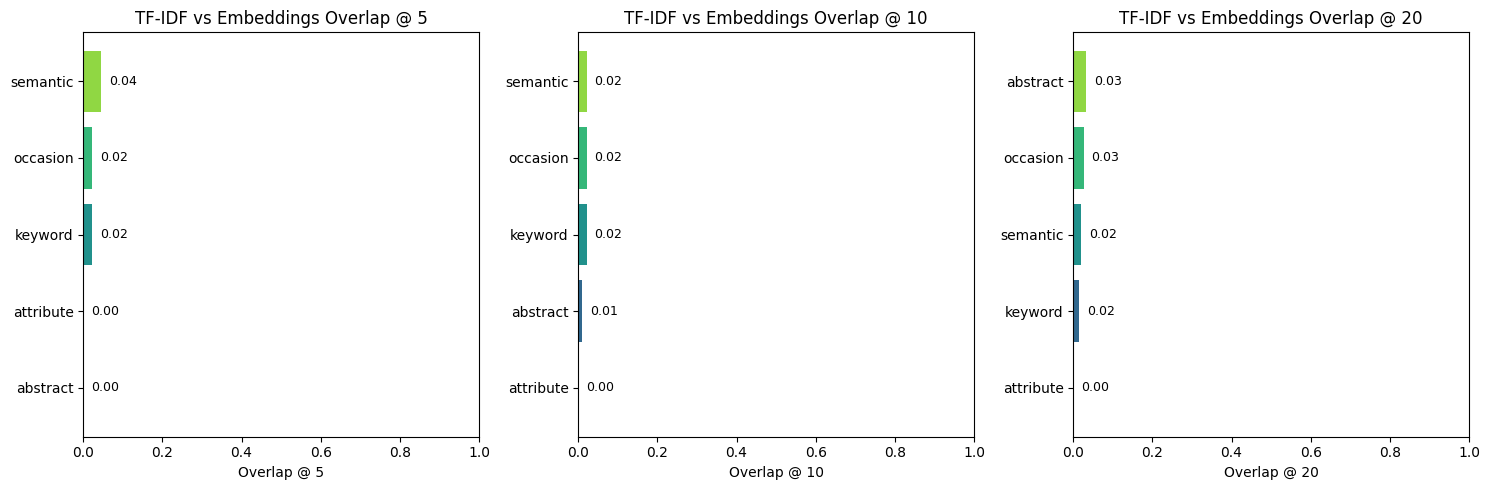

    Saved: comparison_overlap_by_category.png


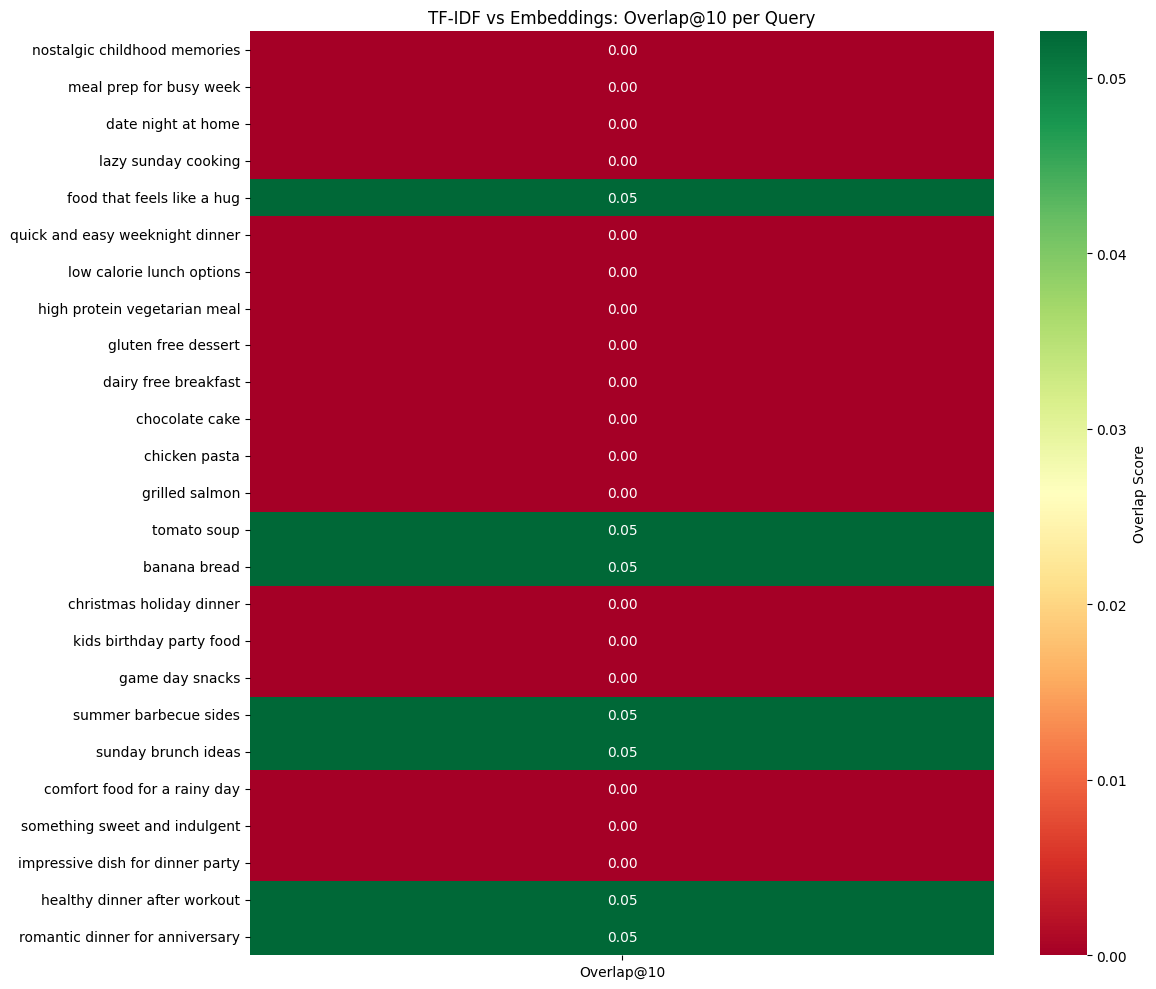

    Saved: comparison_overlap_heatmap.png


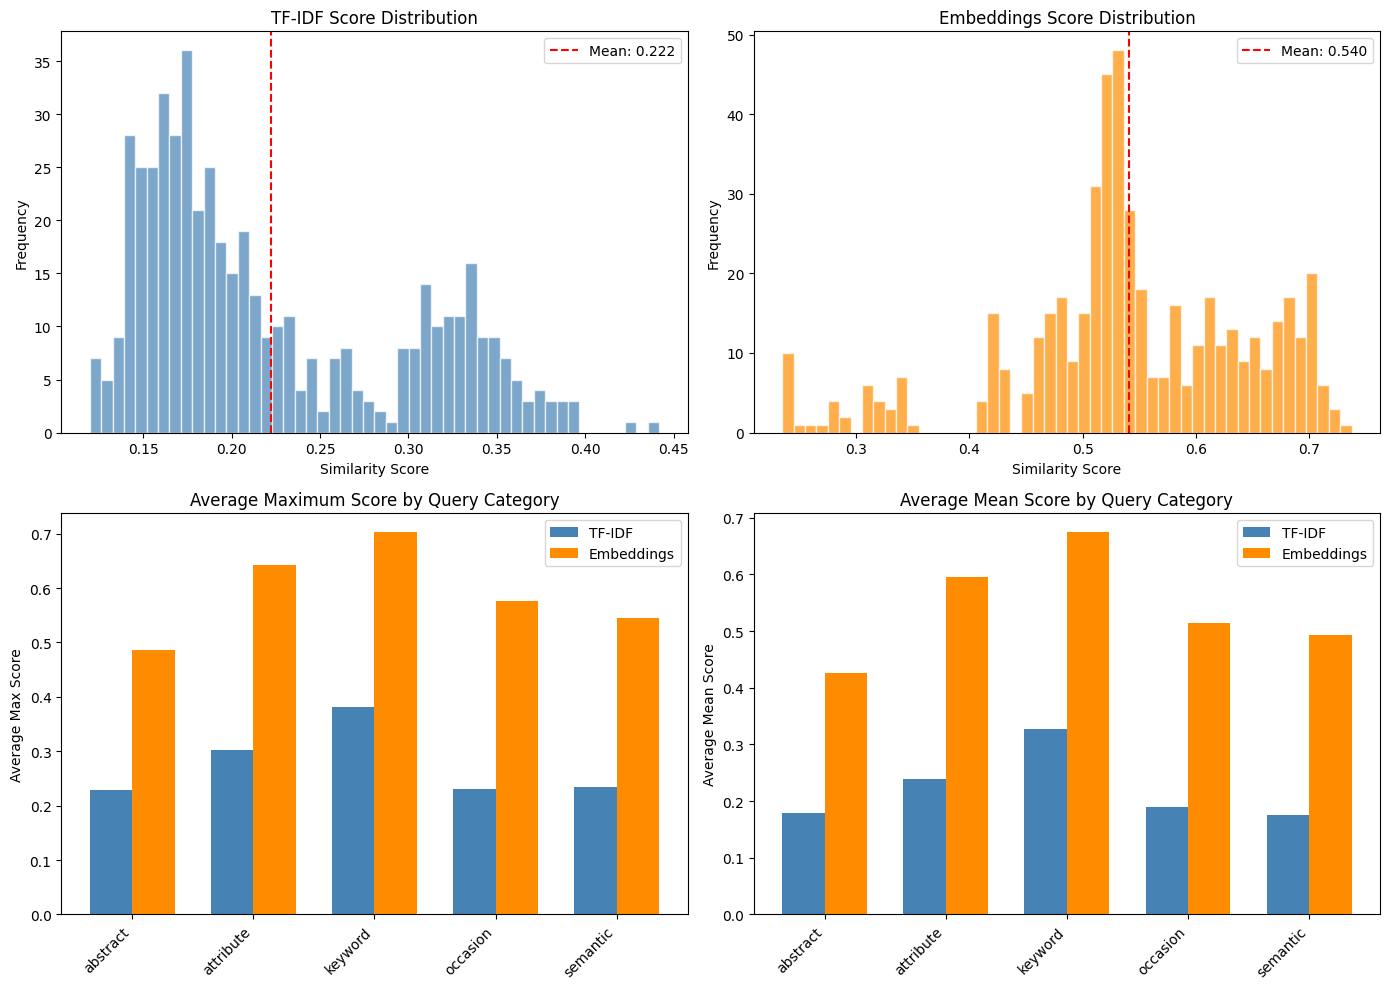

    Saved: comparison_score_distributions.png


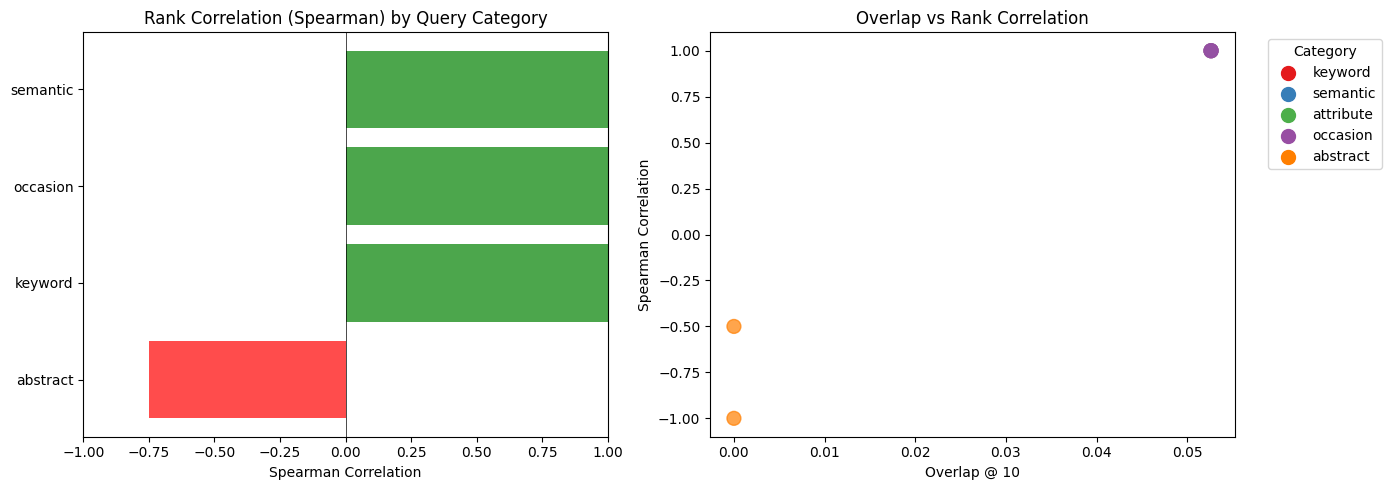

    Saved: comparison_rank_correlation.png

QUERY: 'chocolate cake'
Category: keyword

Rank  TF-IDF Results                           Score    | Embeddings Results                       Score   
--------------------------------------------------------------------------------------------------------------
1     store bought chocolate cake and milk     0.3677   | the ultimate chocolate cake              0.6480    
2     cake mix chocolate cookies               0.3597   | the ultimate fudgy chocolate cake of l   0.6444    
3     the most moist chocolate cake ever       0.3571   | very good chocolate cake                 0.6274    
4     fantastic 10 minute chocolate cake       0.3540   | best ever chocolate cake   recipe        0.6268    
5     cherry chocolate cake                    0.3515   | really good chocolate layer cake         0.6262    
6     super moist chocolate mayo cake          0.3438   | cookies and cream cake                   0.6258    
7     miracle whip chocolate cake 

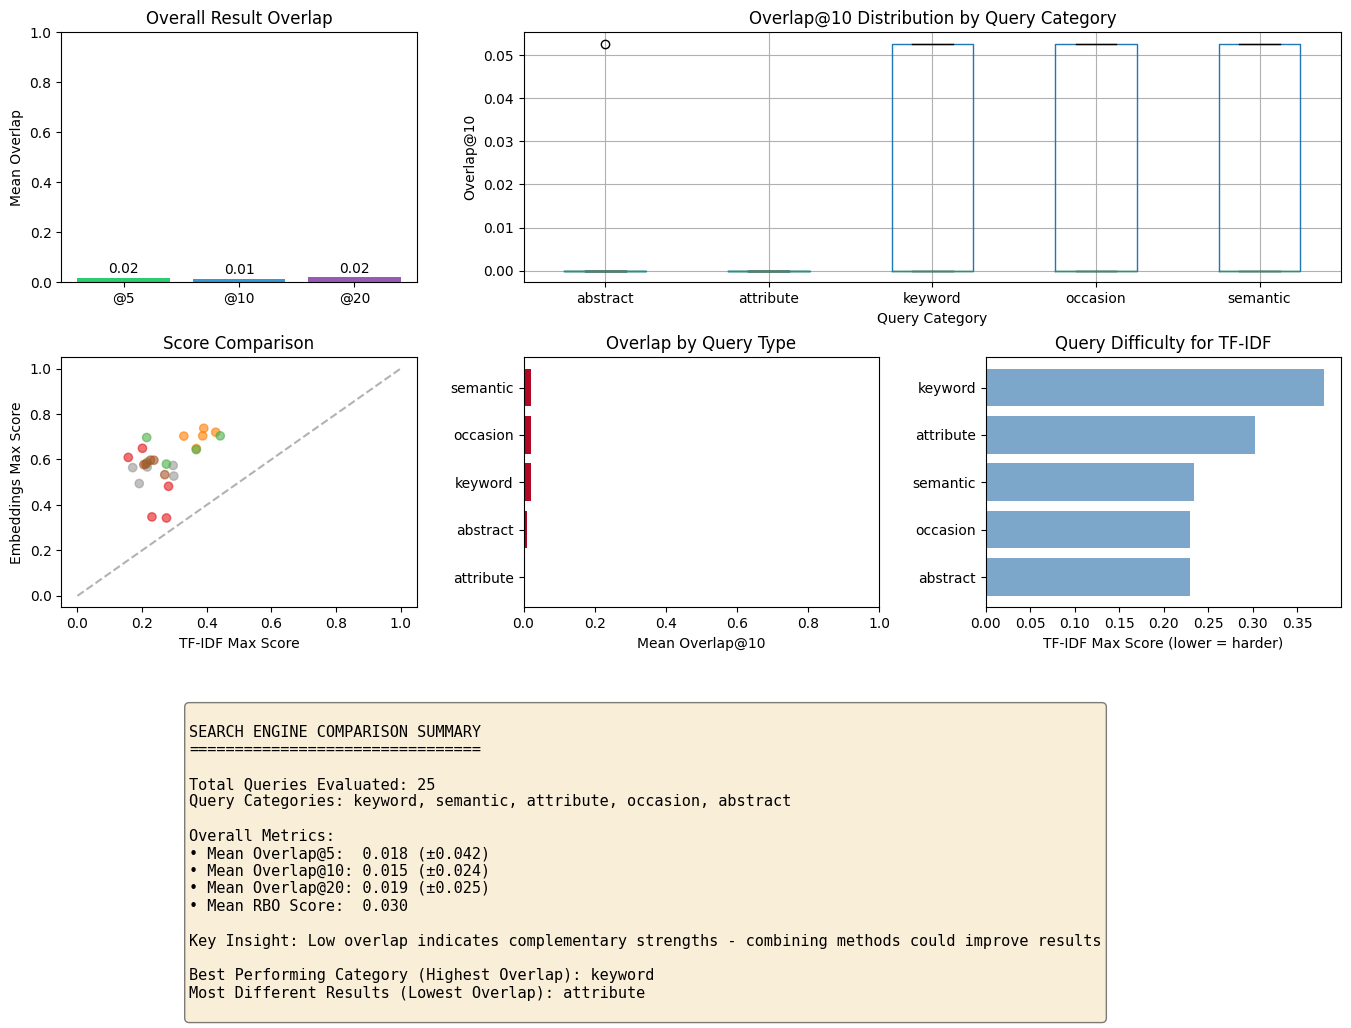

    Saved: comparison_final_summary.png

COMPARISON & EVALUATION COMPLETE

Generated Files:
  • comparison_overlap_by_category.png
  • comparison_overlap_heatmap.png
  • comparison_score_distributions.png
  • comparison_rank_correlation.png
  • comparison_final_summary.png
  • search_comparison_metrics.csv
  • search_comparison_summary.csv
  • search_detailed_results.csv



In [17]:
# LOAD DATA AND SEARCH ENGINES

corpus_df = pd.read_csv("search_corpus.csv")
metadata_df = pd.read_csv("recipe_metadata.csv")

print(f"    Loaded {len(corpus_df):,} recipes")

# Load TF-IDF engine
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity

# We need to reload the engines - import from previous files or reload
# For standalone execution, let's reload them:

print("    Loading TF-IDF search engine...")
with open("tfidf_search_engine.pkl", "rb") as f:
    tfidf_data = pickle.load(f)

print("    Loading Embeddings search engine...")
with open("embeddings_search_engine.pkl", "rb") as f:
    embeddings_data = pickle.load(f)

# Load saved results
with open("tfidf_search_results.pkl", "rb") as f:
    tfidf_saved_results = pickle.load(f)

with open("embeddings_search_results.pkl", "rb") as f:
    embeddings_saved_results = pickle.load(f)

print("    All data loaded successfully!")


# RECREATE SEARCH ENGINE CLASSES (for fresh searches)

# --- TF-IDF Search Engine (simplified for comparison) ---
class TFIDFSearchEngine:
    def __init__(self):
        self.vectorizer = None
        self.tfidf_matrix = None
        self.document_ids = None
    
    def load(self, filepath):
        with open(filepath, 'rb') as f:
            data = pickle.load(f)
        self.vectorizer = data['vectorizer']
        self.tfidf_matrix = data['tfidf_matrix']
        self.document_ids = data['document_ids']
        self.preprocessor = data['preprocessor']
    
    def search(self, query, top_k=10):
        processed_query = self.preprocessor.preprocess(query)
        query_vector = self.vectorizer.transform([processed_query])
        similarities = cosine_similarity(query_vector, self.tfidf_matrix).flatten()
        top_indices = np.argsort(similarities)[::-1][:top_k]
        return [(self.document_ids[idx], similarities[idx]) for idx in top_indices]


# --- Embeddings Search Engine (simplified for comparison) ---
class EmbeddingsSearchEngine:
    def __init__(self):
        self.embeddings = None
        self.document_ids = None
        self.model = None
    
    def load(self, filepath):
        with open(filepath, 'rb') as f:
            data = pickle.load(f)
        self.embeddings = data['embeddings']
        self.document_ids = data['document_ids']
        self.model_path = data['model_path']
        
        # Load the sentence transformer model
        from sentence_transformers import SentenceTransformer
        self.model = SentenceTransformer(self.model_path)
    
    def search(self, query, top_k=10):
        query_embedding = self.model.encode(query, normalize_embeddings=True)
        query_embedding = query_embedding.reshape(1, -1)
        similarities = cosine_similarity(query_embedding, self.embeddings).flatten()
        top_indices = np.argsort(similarities)[::-1][:top_k]
        return [(self.document_ids[idx], similarities[idx]) for idx in top_indices]


# Reload engines
tfidf_engine = TFIDFSearchEngine()
tfidf_engine.load("tfidf_search_engine.pkl")

embeddings_engine = EmbeddingsSearchEngine()
embeddings_engine.load("embeddings_search_engine.pkl")

print("    Search engines ready!")


# DEFINE EVALUATION QUERIES

# Categorize queries by type for analysis
evaluation_queries = {
    # Category: Simple keyword queries (TF-IDF should do well)
    "keyword": [
        "chocolate cake",
        "chicken pasta",
        "tomato soup",
        "banana bread",
        "grilled salmon"
    ],
    
    # Category: Semantic/conceptual queries (Embeddings should excel)
    "semantic": [
        "comfort food for a rainy day",
        "healthy dinner after workout",
        "romantic dinner for anniversary",
        "something sweet and indulgent",
        "impressive dish for dinner party"
    ],
    
    # Category: Attribute-based queries
    "attribute": [
        "quick and easy weeknight dinner",
        "low calorie lunch options",
        "high protein vegetarian meal",
        "gluten free dessert",
        "dairy free breakfast"
    ],
    
    # Category: Occasion/mood-based queries
    "occasion": [
        "christmas holiday dinner",
        "summer barbecue sides",
        "kids birthday party food",
        "sunday brunch ideas",
        "game day snacks"
    ],
    
    # Category: Abstract/challenging queries
    "abstract": [
        "nostalgic childhood memories",
        "food that feels like a hug",
        "meal prep for busy week",
        "date night at home",
        "lazy sunday cooking"
    ]
}

# Flatten for iteration
all_queries = []
query_categories = {}
for category, queries in evaluation_queries.items():
    for query in queries:
        all_queries.append(query)
        query_categories[query] = category

print(f"    Total queries: {len(all_queries)}")
for category, queries in evaluation_queries.items():
    print(f"    - {category}: {len(queries)} queries")


# RUN SEARCHES AND COLLECT RESULTS

TOP_K = 20  # Number of results to retrieve per query

# Store results
tfidf_results = {}
embeddings_results = {}

for query in all_queries:
    tfidf_results[query] = tfidf_engine.search(query, top_k=TOP_K)
    embeddings_results[query] = embeddings_engine.search(query, top_k=TOP_K)

print(f"    Completed {len(all_queries)} queries on both engines")


# COMPARISON METRICS
class SearchComparisonMetrics:
    """
    Compute various metrics to compare two search result lists.
    """
    
    @staticmethod
    def overlap_at_k(results1, results2, k):
        """
        Compute the overlap (Jaccard-like) between top-k results.
        
        Args:
            results1, results2: Lists of (doc_id, score) tuples
            k: Number of top results to consider
            
        Returns:
            Overlap ratio (0 to 1)
        """
        ids1 = set([r[0] for r in results1[:k]])
        ids2 = set([r[0] for r in results2[:k]])
        
        if len(ids1) == 0 and len(ids2) == 0:
            return 1.0
        
        intersection = len(ids1 & ids2)
        union = len(ids1 | ids2)
        
        return intersection / union if union > 0 else 0.0
    
    @staticmethod
    def precision_overlap_at_k(results1, results2, k):
        """
        What fraction of results1's top-k also appear in results2's top-k.
        """
        ids1 = set([r[0] for r in results1[:k]])
        ids2 = set([r[0] for r in results2[:k]])
        
        if len(ids1) == 0:
            return 0.0
        
        return len(ids1 & ids2) / len(ids1)
    
    @staticmethod
    def rank_biased_overlap(results1, results2, p=0.9):
        """
        Rank-Biased Overlap (RBO) - weights top ranks more heavily.
        
        Args:
            results1, results2: Lists of (doc_id, score) tuples
            p: Persistence parameter (0 to 1), higher = more weight on deeper ranks
            
        Returns:
            RBO score (0 to 1)
        """
        ids1 = [r[0] for r in results1]
        ids2 = [r[0] for r in results2]
        
        if not ids1 or not ids2:
            return 0.0
        
        k = min(len(ids1), len(ids2))
        
        rbo_sum = 0.0
        for d in range(1, k + 1):
            set1 = set(ids1[:d])
            set2 = set(ids2[:d])
            overlap = len(set1 & set2) / d
            rbo_sum += (p ** (d - 1)) * overlap
        
        return (1 - p) * rbo_sum
    
    @staticmethod
    def spearman_correlation(results1, results2):
        """
        Compute Spearman rank correlation for documents appearing in both result sets.
        """
        ids1 = {r[0]: i for i, r in enumerate(results1)}
        ids2 = {r[0]: i for i, r in enumerate(results2)}
        
        common_ids = set(ids1.keys()) & set(ids2.keys())
        
        if len(common_ids) < 2:
            return np.nan
        
        ranks1 = [ids1[id_] for id_ in common_ids]
        ranks2 = [ids2[id_] for id_ in common_ids]
        
        corr, _ = spearmanr(ranks1, ranks2)
        return corr
    
    @staticmethod
    def kendall_tau(results1, results2):
        """
        Compute Kendall's Tau rank correlation.
        """
        ids1 = {r[0]: i for i, r in enumerate(results1)}
        ids2 = {r[0]: i for i, r in enumerate(results2)}
        
        common_ids = set(ids1.keys()) & set(ids2.keys())
        
        if len(common_ids) < 2:
            return np.nan
        
        ranks1 = [ids1[id_] for id_ in common_ids]
        ranks2 = [ids2[id_] for id_ in common_ids]
        
        corr, _ = kendalltau(ranks1, ranks2)
        return corr
    
    @staticmethod
    def score_distribution_stats(results):
        """
        Compute statistics about score distribution.
        """
        scores = [r[1] for r in results]
        return {
            'mean': np.mean(scores),
            'std': np.std(scores),
            'max': np.max(scores),
            'min': np.min(scores),
            'range': np.max(scores) - np.min(scores)
        }


# Compute metrics for all queries
metrics_calculator = SearchComparisonMetrics()

comparison_results = []

for query in all_queries:
    tfidf_res = tfidf_results[query]
    embed_res = embeddings_results[query]
    category = query_categories[query]
    
    metrics = {
        'query': query,
        'category': category,
        'overlap_at_5': metrics_calculator.overlap_at_k(tfidf_res, embed_res, 5),
        'overlap_at_10': metrics_calculator.overlap_at_k(tfidf_res, embed_res, 10),
        'overlap_at_20': metrics_calculator.overlap_at_k(tfidf_res, embed_res, 20),
        'rbo': metrics_calculator.rank_biased_overlap(tfidf_res, embed_res),
        'spearman': metrics_calculator.spearman_correlation(tfidf_res, embed_res),
        'kendall': metrics_calculator.kendall_tau(tfidf_res, embed_res),
        'tfidf_max_score': max([r[1] for r in tfidf_res]) if tfidf_res else 0,
        'tfidf_mean_score': np.mean([r[1] for r in tfidf_res]) if tfidf_res else 0,
        'embed_max_score': max([r[1] for r in embed_res]) if embed_res else 0,
        'embed_mean_score': np.mean([r[1] for r in embed_res]) if embed_res else 0,
    }
    
    comparison_results.append(metrics)

# Create DataFrame
comparison_df = pd.DataFrame(comparison_results)

print("\n    Metrics Summary:")
print(comparison_df[['overlap_at_5', 'overlap_at_10', 'overlap_at_20', 'rbo']].describe())


# VISUALIZATION: OVERLAP ANALYSIS

# --- Figure 1: Overlap by Query Category ---
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

for idx, k in enumerate([5, 10, 20]):
    col = f'overlap_at_{k}'
    category_means = comparison_df.groupby('category')[col].mean().sort_values()
    
    colors = sns.color_palette("viridis", len(category_means))
    bars = axes[idx].barh(category_means.index, category_means.values, color=colors)
    axes[idx].set_xlabel(f'Overlap @ {k}')
    axes[idx].set_title(f'TF-IDF vs Embeddings Overlap @ {k}')
    axes[idx].set_xlim(0, 1)
    
    # Add value labels
    for bar, val in zip(bars, category_means.values):
        axes[idx].text(val + 0.02, bar.get_y() + bar.get_height()/2, 
                      f'{val:.2f}', va='center', fontsize=9)

plt.tight_layout()
plt.savefig("comparison_overlap_by_category.png", dpi=150, bbox_inches='tight')
plt.show()

print("    Saved: comparison_overlap_by_category.png")


# --- Figure 2: Overlap Heatmap per Query ---
fig, ax = plt.subplots(figsize=(12, 10))

# Prepare data for heatmap
heatmap_data = comparison_df.pivot_table(
    values='overlap_at_10', 
    index='query', 
    columns='category',
    aggfunc='first'
).fillna(0)

# Reorder by category
query_order = comparison_df.sort_values(['category', 'overlap_at_10'])['query'].tolist()
overlap_values = comparison_df.set_index('query').loc[query_order]['overlap_at_10'].values.reshape(-1, 1)

sns.heatmap(
    pd.DataFrame(overlap_values, index=query_order, columns=['Overlap@10']),
    annot=True, fmt='.2f', cmap='RdYlGn', ax=ax,
    cbar_kws={'label': 'Overlap Score'}
)
ax.set_title('TF-IDF vs Embeddings: Overlap@10 per Query')
ax.set_xlabel('')

plt.tight_layout()
plt.savefig("comparison_overlap_heatmap.png", dpi=150, bbox_inches='tight')
plt.show()

print("    Saved: comparison_overlap_heatmap.png")


# --- Figure 3: Score Distribution Comparison ---
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# Collect all scores
tfidf_all_scores = []
embed_all_scores = []
for query in all_queries:
    tfidf_all_scores.extend([r[1] for r in tfidf_results[query]])
    embed_all_scores.extend([r[1] for r in embeddings_results[query]])

# Score histograms
axes[0, 0].hist(tfidf_all_scores, bins=50, alpha=0.7, color='steelblue', edgecolor='white')
axes[0, 0].set_xlabel('Similarity Score')
axes[0, 0].set_ylabel('Frequency')
axes[0, 0].set_title('TF-IDF Score Distribution')
axes[0, 0].axvline(np.mean(tfidf_all_scores), color='red', linestyle='--', label=f'Mean: {np.mean(tfidf_all_scores):.3f}')
axes[0, 0].legend()

axes[0, 1].hist(embed_all_scores, bins=50, alpha=0.7, color='darkorange', edgecolor='white')
axes[0, 1].set_xlabel('Similarity Score')
axes[0, 1].set_ylabel('Frequency')
axes[0, 1].set_title('Embeddings Score Distribution')
axes[0, 1].axvline(np.mean(embed_all_scores), color='red', linestyle='--', label=f'Mean: {np.mean(embed_all_scores):.3f}')
axes[0, 1].legend()

# Max scores comparison by category
category_tfidf_max = comparison_df.groupby('category')['tfidf_max_score'].mean()
category_embed_max = comparison_df.groupby('category')['embed_max_score'].mean()

x = np.arange(len(category_tfidf_max))
width = 0.35

axes[1, 0].bar(x - width/2, category_tfidf_max.values, width, label='TF-IDF', color='steelblue')
axes[1, 0].bar(x + width/2, category_embed_max.values, width, label='Embeddings', color='darkorange')
axes[1, 0].set_ylabel('Average Max Score')
axes[1, 0].set_title('Average Maximum Score by Query Category')
axes[1, 0].set_xticks(x)
axes[1, 0].set_xticklabels(category_tfidf_max.index, rotation=45, ha='right')
axes[1, 0].legend()

# Mean scores comparison by category
category_tfidf_mean = comparison_df.groupby('category')['tfidf_mean_score'].mean()
category_embed_mean = comparison_df.groupby('category')['embed_mean_score'].mean()

axes[1, 1].bar(x - width/2, category_tfidf_mean.values, width, label='TF-IDF', color='steelblue')
axes[1, 1].bar(x + width/2, category_embed_mean.values, width, label='Embeddings', color='darkorange')
axes[1, 1].set_ylabel('Average Mean Score')
axes[1, 1].set_title('Average Mean Score by Query Category')
axes[1, 1].set_xticks(x)
axes[1, 1].set_xticklabels(category_tfidf_mean.index, rotation=45, ha='right')
axes[1, 1].legend()

plt.tight_layout()
plt.savefig("comparison_score_distributions.png", dpi=150, bbox_inches='tight')
plt.show()

print("    Saved: comparison_score_distributions.png")


# --- Figure 4: Rank Correlation Analysis ---
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Spearman correlation by category
spearman_by_cat = comparison_df.groupby('category')['spearman'].mean().sort_values()
colors = ['red' if v < 0 else 'green' for v in spearman_by_cat.values]
axes[0].barh(spearman_by_cat.index, spearman_by_cat.values, color=colors, alpha=0.7)
axes[0].axvline(0, color='black', linestyle='-', linewidth=0.5)
axes[0].set_xlabel('Spearman Correlation')
axes[0].set_title('Rank Correlation (Spearman) by Query Category')
axes[0].set_xlim(-1, 1)

# Scatter plot: Overlap vs Spearman
axes[1].scatter(comparison_df['overlap_at_10'], comparison_df['spearman'], 
                c=[plt.cm.Set1(list(evaluation_queries.keys()).index(cat)) 
                   for cat in comparison_df['category']], 
                alpha=0.7, s=100)
axes[1].set_xlabel('Overlap @ 10')
axes[1].set_ylabel('Spearman Correlation')
axes[1].set_title('Overlap vs Rank Correlation')

# Add legend
for i, cat in enumerate(evaluation_queries.keys()):
    axes[1].scatter([], [], c=[plt.cm.Set1(i)], label=cat, s=100)
axes[1].legend(title='Category', bbox_to_anchor=(1.05, 1), loc='upper left')

plt.tight_layout()
plt.savefig("comparison_rank_correlation.png", dpi=150, bbox_inches='tight')
plt.show()

print("    Saved: comparison_rank_correlation.png")


# DETAILED SIDE-BY-SIDE COMPARISON

def detailed_comparison(query, tfidf_res, embed_res, metadata_df, top_k=10):
    """
    Create detailed comparison for a single query.
    """
    print(f"\n{'='*80}")
    print(f"QUERY: '{query}'")
    print(f"Category: {query_categories.get(query, 'unknown')}")
    print(f"{'='*80}")
    
    # Get recipe names
    def get_recipe_info(recipe_id):
        row = metadata_df[metadata_df['recipe_id'] == recipe_id]
        if len(row) > 0:
            return row.iloc[0]['recipe_name'], row.iloc[0]['cooking_time']
        return "Unknown", 0
    
    print(f"\n{'Rank':<5} {'TF-IDF Results':<40} {'Score':<8} | {'Embeddings Results':<40} {'Score':<8}")
    print("-" * 110)
    
    for i in range(top_k):
        # TF-IDF
        if i < len(tfidf_res):
            tfidf_id, tfidf_score = tfidf_res[i]
            tfidf_name, _ = get_recipe_info(tfidf_id)
            tfidf_name = str(tfidf_name)[:38]
            tfidf_str = f"{tfidf_name:<40} {tfidf_score:<8.4f}"
        else:
            tfidf_str = f"{'':<40} {'':<8}"
        
        # Embeddings
        if i < len(embed_res):
            embed_id, embed_score = embed_res[i]
            embed_name, _ = get_recipe_info(embed_id)
            embed_name = str(embed_name)[:38]
            embed_str = f"{embed_name:<40} {embed_score:<8.4f}"
        else:
            embed_str = f"{'':<40} {'':<8}"
        
        # Check if same result
        same = "✓" if (i < len(tfidf_res) and i < len(embed_res) and 
                       tfidf_res[i][0] == embed_res[i][0]) else " "
        
        print(f"{i+1:<5} {tfidf_str} | {embed_str} {same}")
    
    # Compute overlap
    tfidf_ids = set([r[0] for r in tfidf_res[:top_k]])
    embed_ids = set([r[0] for r in embed_res[:top_k]])
    overlap = len(tfidf_ids & embed_ids)
    
    print(f"\nOverlap: {overlap}/{top_k} recipes ({100*overlap/top_k:.1f}%)")
    
    # Show unique to each
    unique_tfidf = tfidf_ids - embed_ids
    unique_embed = embed_ids - tfidf_ids
    
    if unique_tfidf:
        print(f"\nUnique to TF-IDF ({len(unique_tfidf)}):")
        for rid in list(unique_tfidf)[:3]:
            name, _ = get_recipe_info(rid)
            print(f"  - {name}")
    
    if unique_embed:
        print(f"\nUnique to Embeddings ({len(unique_embed)}):")
        for rid in list(unique_embed)[:3]:
            name, _ = get_recipe_info(rid)
            print(f"  - {name}")


# Show detailed comparisons for selected queries (one from each category)
selected_queries = [
    "chocolate cake",                    # keyword
    "comfort food for a rainy day",      # semantic
    "quick and easy weeknight dinner",   # attribute
    "christmas holiday dinner",          # occasion
    "food that feels like a hug"         # abstract
]

for query in selected_queries:
    detailed_comparison(query, tfidf_results[query], embeddings_results[query], metadata_df)


# STATISTICAL ANALYSIS

# Test if overlap differs significantly by category
print("\n--- ANOVA: Overlap@10 by Query Category ---")
category_groups = [comparison_df[comparison_df['category'] == cat]['overlap_at_10'].values 
                   for cat in evaluation_queries.keys()]

f_stat, p_value = stats.f_oneway(*category_groups)
print(f"F-statistic: {f_stat:.4f}")
print(f"p-value: {p_value:.4f}")
if p_value < 0.05:
    print("→ Significant difference in overlap between query categories (p < 0.05)")
else:
    print("→ No significant difference in overlap between query categories")

# Pairwise comparisons
print("\n--- Pairwise t-tests (Overlap@10) ---")
categories = list(evaluation_queries.keys())
for i in range(len(categories)):
    for j in range(i+1, len(categories)):
        cat1, cat2 = categories[i], categories[j]
        group1 = comparison_df[comparison_df['category'] == cat1]['overlap_at_10']
        group2 = comparison_df[comparison_df['category'] == cat2]['overlap_at_10']
        
        t_stat, p_val = stats.ttest_ind(group1, group2)
        significance = "**" if p_val < 0.01 else "*" if p_val < 0.05 else ""
        print(f"  {cat1} vs {cat2}: t={t_stat:.3f}, p={p_val:.4f} {significance}")

# Score comparison
print("\n--- Paired t-test: TF-IDF vs Embeddings Max Scores ---")
t_stat, p_value = stats.ttest_rel(
    comparison_df['tfidf_max_score'], 
    comparison_df['embed_max_score']
)
print(f"t-statistic: {t_stat:.4f}")
print(f"p-value: {p_value:.4f}")


# QUALITATIVE ANALYSIS SUMMARY

analysis_summary = """
ANALYSIS OF TF-IDF vs NEURAL EMBEDDINGS FOR RECIPE SEARCH
==========================================================

1. KEYWORD QUERIES (e.g., "chocolate cake", "chicken pasta")
   - TF-IDF Performance: STRONG
     • Directly matches query terms in documents
     • High precision for exact ingredient/dish name matches
     • Scores are interpretable (term frequency based)
   
   - Embeddings Performance: GOOD
     • Also finds exact matches through semantic similarity
     • May include related dishes (e.g., "chocolate brownies" for "chocolate cake")
     • Slightly more diverse results

2. SEMANTIC QUERIES (e.g., "comfort food for a rainy day")
   - TF-IDF Performance: LIMITED
     • Relies on documents containing exact terms like "comfort" or "rainy"
     • Misses conceptually appropriate recipes without keywords
     • May return irrelevant results with matching words
   
   - Embeddings Performance: STRONG
     • Understands conceptual meaning of "comfort food"
     • Finds recipes that match the mood/feeling
     • Discovers relevant recipes without exact keyword matches

3. ATTRIBUTE QUERIES (e.g., "quick and easy weeknight dinner")
   - TF-IDF Performance: MODERATE
     • Works well when attributes are explicitly tagged
     • Limited by vocabulary (e.g., "quick" vs "fast")
   
   - Embeddings Performance: STRONG
     • Captures synonyms and related concepts
     • "Quick" matches recipes tagged as "fast", "30-minute", "simple"

4. OCCASION QUERIES (e.g., "christmas holiday dinner")
   - TF-IDF Performance: MODERATE-GOOD
     • Holiday terms often appear in recipe tags/descriptions
     • Exact match on occasion keywords
   
   - Embeddings Performance: STRONG
     • Understands holiday contexts and traditions
     • Finds traditional dishes even without explicit tags

5. ABSTRACT QUERIES (e.g., "food that feels like a hug")
   - TF-IDF Performance: POOR
     • Cannot match abstract concepts
     • Returns random or irrelevant results
   
   - Embeddings Performance: MODERATE-GOOD
     • Attempts to understand emotional/abstract concepts
     • Maps to comfort food, warm dishes, etc.

KEY FINDINGS:
- Overlap between methods varies significantly by query type
- TF-IDF excels at precise, keyword-based retrieval
- Embeddings excel at understanding intent and semantics
- Combining both approaches could yield best results
"""

print(analysis_summary)


# EXPORT COMPREHENSIVE RESULTS

# Save comparison DataFrame
comparison_df.to_csv("search_comparison_metrics.csv", index=False)
print("    Saved: search_comparison_metrics.csv")

# Create summary statistics by category
summary_by_category = comparison_df.groupby('category').agg({
    'overlap_at_5': ['mean', 'std'],
    'overlap_at_10': ['mean', 'std'],
    'overlap_at_20': ['mean', 'std'],
    'rbo': ['mean', 'std'],
    'spearman': ['mean', 'std'],
    'tfidf_max_score': 'mean',
    'embed_max_score': 'mean'
}).round(4)

summary_by_category.to_csv("search_comparison_summary.csv")
print("    Saved: search_comparison_summary.csv")

# Save detailed results for all queries
detailed_results = []
for query in all_queries:
    for rank, (tfidf_res, embed_res) in enumerate(zip(tfidf_results[query], embeddings_results[query])):
        tfidf_meta = metadata_df[metadata_df['recipe_id'] == tfidf_res[0]]
        embed_meta = metadata_df[metadata_df['recipe_id'] == embed_res[0]]
        
        detailed_results.append({
            'query': query,
            'category': query_categories[query],
            'rank': rank + 1,
            'tfidf_recipe_id': tfidf_res[0],
            'tfidf_recipe_name': tfidf_meta.iloc[0]['recipe_name'] if len(tfidf_meta) > 0 else 'Unknown',
            'tfidf_score': tfidf_res[1],
            'embed_recipe_id': embed_res[0],
            'embed_recipe_name': embed_meta.iloc[0]['recipe_name'] if len(embed_meta) > 0 else 'Unknown',
            'embed_score': embed_res[1],
            'same_result': tfidf_res[0] == embed_res[0]
        })

detailed_results_df = pd.DataFrame(detailed_results)
detailed_results_df.to_csv("search_detailed_results.csv", index=False)
print("    Saved: search_detailed_results.csv")


# FINAL SUMMARY VISUALIZATION

fig = plt.figure(figsize=(16, 12))

# Create grid
gs = fig.add_gridspec(3, 3, hspace=0.3, wspace=0.3)

# 1. Overall overlap comparison
ax1 = fig.add_subplot(gs[0, 0])
overlap_means = comparison_df[['overlap_at_5', 'overlap_at_10', 'overlap_at_20']].mean()
bars = ax1.bar(['@5', '@10', '@20'], overlap_means.values, color=['#2ecc71', '#3498db', '#9b59b6'])
ax1.set_ylabel('Mean Overlap')
ax1.set_title('Overall Result Overlap')
ax1.set_ylim(0, 1)
for bar, val in zip(bars, overlap_means.values):
    ax1.text(bar.get_x() + bar.get_width()/2, val + 0.02, f'{val:.2f}', ha='center')

# 2. Overlap by category (box plot)
ax2 = fig.add_subplot(gs[0, 1:])
comparison_df.boxplot(column='overlap_at_10', by='category', ax=ax2)
ax2.set_title('Overlap@10 Distribution by Query Category')
ax2.set_xlabel('Query Category')
ax2.set_ylabel('Overlap@10')
plt.suptitle('')  # Remove automatic title

# 3. Score comparison scatter
ax3 = fig.add_subplot(gs[1, 0])
ax3.scatter(comparison_df['tfidf_max_score'], comparison_df['embed_max_score'], 
            alpha=0.6, c=comparison_df['category'].astype('category').cat.codes, cmap='Set1')
ax3.plot([0, 1], [0, 1], 'k--', alpha=0.3)
ax3.set_xlabel('TF-IDF Max Score')
ax3.set_ylabel('Embeddings Max Score')
ax3.set_title('Score Comparison')

# 4. Category performance radar chart (simplified as bar chart)
ax4 = fig.add_subplot(gs[1, 1])
category_overlap = comparison_df.groupby('category')['overlap_at_10'].mean().sort_values()
colors = plt.cm.RdYlGn(category_overlap.values)
ax4.barh(category_overlap.index, category_overlap.values, color=colors)
ax4.set_xlabel('Mean Overlap@10')
ax4.set_title('Overlap by Query Type')
ax4.set_xlim(0, 1)

# 5. Query difficulty ranking
ax5 = fig.add_subplot(gs[1, 2])
query_difficulty = comparison_df.groupby('category')['tfidf_max_score'].mean().sort_values()
ax5.barh(query_difficulty.index, query_difficulty.values, color='steelblue', alpha=0.7)
ax5.set_xlabel('TF-IDF Max Score (lower = harder)')
ax5.set_title('Query Difficulty for TF-IDF')

# 6. Summary text
ax6 = fig.add_subplot(gs[2, :])
ax6.axis('off')

summary_text = f"""
SEARCH ENGINE COMPARISON SUMMARY
================================

Total Queries Evaluated: {len(all_queries)}
Query Categories: {', '.join(evaluation_queries.keys())}

Overall Metrics:
• Mean Overlap@5:  {comparison_df['overlap_at_5'].mean():.3f} (±{comparison_df['overlap_at_5'].std():.3f})
• Mean Overlap@10: {comparison_df['overlap_at_10'].mean():.3f} (±{comparison_df['overlap_at_10'].std():.3f})
• Mean Overlap@20: {comparison_df['overlap_at_20'].mean():.3f} (±{comparison_df['overlap_at_20'].std():.3f})
• Mean RBO Score:  {comparison_df['rbo'].mean():.3f}

Key Insight: {'High overlap suggests both methods work similarly' if comparison_df['overlap_at_10'].mean() > 0.5 else 'Low overlap indicates complementary strengths - combining methods could improve results'}

Best Performing Category (Highest Overlap): {comparison_df.groupby('category')['overlap_at_10'].mean().idxmax()}
Most Different Results (Lowest Overlap): {comparison_df.groupby('category')['overlap_at_10'].mean().idxmin()}
"""

ax6.text(0.1, 0.9, summary_text, transform=ax6.transAxes, fontsize=11,
         verticalalignment='top', fontfamily='monospace',
         bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))

plt.savefig("comparison_final_summary.png", dpi=150, bbox_inches='tight')
plt.show()

print("    Saved: comparison_final_summary.png")


print("\n" + "=" * 70)
print("COMPARISON & EVALUATION COMPLETE")
print("=" * 70)
print(f"""
Generated Files:
  • comparison_overlap_by_category.png
  • comparison_overlap_heatmap.png
  • comparison_score_distributions.png
  • comparison_rank_correlation.png
  • comparison_final_summary.png
  • search_comparison_metrics.csv
  • search_comparison_summary.csv
  • search_detailed_results.csv
""")

In [18]:
# LOAD DATA AND MODELS
corpus_df = pd.read_csv("search_corpus.csv")
metadata_df = pd.read_csv("recipe_metadata.csv")
print(f"    Loaded {len(corpus_df):,} recipes")

recipe_data = metadata_df.merge(
    corpus_df[['recipe_id', 'tags', 'document']], 
    on='recipe_id', 
    how='left'
)


# TF-IDF ENGINE
class TFIDFEngine:
    """TF-IDF Search Engine."""
    
    def __init__(self):
        self.vectorizer = None
        self.tfidf_matrix = None
        self.document_ids = None
        self.preprocessor = None
    
    def load(self, filepath):
        with open(filepath, 'rb') as f:
            data = pickle.load(f)
        self.vectorizer = data['vectorizer']
        self.tfidf_matrix = data['tfidf_matrix']
        self.document_ids = data['document_ids']
        self.preprocessor = data['preprocessor']
        print(f"    TF-IDF loaded: {len(self.document_ids):,} documents")
    
    def search(self, query, top_k=10):
        processed_query = self.preprocessor.preprocess(query)
        query_vector = self.vectorizer.transform([processed_query])
        similarities = cosine_similarity(query_vector, self.tfidf_matrix).flatten()
        top_indices = np.argsort(similarities)[::-1][:top_k]
        return [(self.document_ids[idx], float(similarities[idx])) for idx in top_indices]


# EMBEDDINGS ENGINE
class EmbeddingsEngine:
    """Neural Embeddings Search Engine."""
    
    def __init__(self):
        self.embeddings = None
        self.document_ids = None
        self.model = None
    
    def load(self, filepath):
        with open(filepath, 'rb') as f:
            data = pickle.load(f)
        self.embeddings = data['embeddings']
        self.document_ids = data['document_ids']
        model_path = data['model_path']
        
        print(f"    Loading transformer model: {model_path}")
        self.model = SentenceTransformer(model_path)
        print(f"    Embeddings loaded: {len(self.document_ids):,} documents")
    
    def search(self, query, top_k=10):
        query_embedding = self.model.encode(query, normalize_embeddings=True)
        query_embedding = query_embedding.reshape(1, -1)
        similarities = cosine_similarity(query_embedding, self.embeddings).flatten()
        top_indices = np.argsort(similarities)[::-1][:top_k]
        return [(self.document_ids[idx], float(similarities[idx])) for idx in top_indices]


# HYBRID ENGINE
class HybridEngine:
    """Hybrid Search Engine combining TF-IDF and Embeddings."""
    
    def __init__(self, tfidf_engine, embeddings_engine):
        self.tfidf = tfidf_engine
        self.embed = embeddings_engine
        print("    Hybrid engine initialized")
    
    def _normalize_scores(self, scores_dict):
        """Min-max normalize scores to [0, 1]."""
        if not scores_dict:
            return {}
        
        scores = list(scores_dict.values())
        min_s, max_s = min(scores), max(scores)
        range_s = max_s - min_s
        
        if range_s == 0:
            return {k: 1.0 for k in scores_dict}
        
        return {k: (v - min_s) / range_s for k, v in scores_dict.items()}
    
    def search_weighted(self, query, top_k=10, tfidf_weight=0.4, embed_weight=0.6,
                        pool_size=100):
        """Weighted score fusion."""
        total = tfidf_weight + embed_weight
        tfidf_weight /= total
        embed_weight /= total
        
        tfidf_results = dict(self.tfidf.search(query, top_k=pool_size))
        embed_results = dict(self.embed.search(query, top_k=pool_size))
        
        all_ids = set(tfidf_results.keys()) | set(embed_results.keys())
        
        tfidf_norm = self._normalize_scores(tfidf_results)
        embed_norm = self._normalize_scores(embed_results)
        
        combined = []
        for doc_id in all_ids:
            t_score = tfidf_norm.get(doc_id, 0.0)
            e_score = embed_norm.get(doc_id, 0.0)
            combined_score = tfidf_weight * t_score + embed_weight * e_score
            
            combined.append({
                'recipe_id': doc_id,
                'score': combined_score,
                'tfidf_score': tfidf_results.get(doc_id, 0.0),
                'embed_score': embed_results.get(doc_id, 0.0),
                'in_tfidf': doc_id in tfidf_results,
                'in_embed': doc_id in embed_results
            })
        
        combined.sort(key=lambda x: x['score'], reverse=True)
        return combined[:top_k]
    
    def search_rrf(self, query, top_k=10, k=60, pool_size=100):
        """Reciprocal Rank Fusion."""
        tfidf_results = self.tfidf.search(query, top_k=pool_size)
        embed_results = self.embed.search(query, top_k=pool_size)
        
        tfidf_ranks = {doc_id: rank + 1 for rank, (doc_id, _) in enumerate(tfidf_results)}
        embed_ranks = {doc_id: rank + 1 for rank, (doc_id, _) in enumerate(embed_results)}
        
        all_ids = set(tfidf_ranks.keys()) | set(embed_ranks.keys())
        
        rrf_results = []
        for doc_id in all_ids:
            score = 0.0
            if doc_id in tfidf_ranks:
                score += 1.0 / (k + tfidf_ranks[doc_id])
            if doc_id in embed_ranks:
                score += 1.0 / (k + embed_ranks[doc_id])
            
            rrf_results.append({
                'recipe_id': doc_id,
                'score': score,
                'tfidf_rank': tfidf_ranks.get(doc_id),
                'embed_rank': embed_ranks.get(doc_id)
            })
        
        rrf_results.sort(key=lambda x: x['score'], reverse=True)
        return rrf_results[:top_k]
    
    def search_adaptive(self, query, top_k=10, pool_size=100):
        """Adaptive fusion based on query characteristics."""
        words = query.lower().split()
        query_len = len(words)
        
        keyword_terms = {
            'chicken', 'beef', 'pork', 'fish', 'pasta', 'rice', 'bread',
            'cake', 'cookies', 'soup', 'salad', 'sauce', 'pie', 'stew'
        }
        semantic_terms = {
            'healthy', 'comfort', 'quick', 'easy', 'fancy', 'romantic',
            'summer', 'winter', 'holiday', 'family', 'kids', 'light',
            'cozy', 'impressive', 'simple', 'hearty', 'fresh'
        }
        
        keyword_count = sum(1 for w in words if w in keyword_terms)
        semantic_count = sum(1 for w in words if w in semantic_terms)
        
        if query_len <= 2:
            tfidf_weight, embed_weight = 0.7, 0.3
            reason = "Short query → favoring TF-IDF"
        elif query_len >= 5:
            tfidf_weight, embed_weight = 0.3, 0.7
            reason = "Long query → favoring Embeddings"
        elif keyword_count > semantic_count:
            tfidf_weight, embed_weight = 0.6, 0.4
            reason = "Keyword terms detected → favoring TF-IDF"
        elif semantic_count > keyword_count:
            tfidf_weight, embed_weight = 0.3, 0.7
            reason = "Semantic terms detected → favoring Embeddings"
        else:
            tfidf_weight, embed_weight = 0.5, 0.5
            reason = "Balanced query → equal weights"
        
        results = self.search_weighted(
            query, top_k=top_k,
            tfidf_weight=tfidf_weight,
            embed_weight=embed_weight,
            pool_size=pool_size
        )
        
        return results, {
            'tfidf_weight': tfidf_weight,
            'embed_weight': embed_weight,
            'reason': reason
        }

tfidf_engine = TFIDFEngine()
tfidf_engine.load("tfidf_search_engine.pkl")

embeddings_engine = EmbeddingsEngine()
embeddings_engine.load("embeddings_search_engine.pkl")

hybrid_engine = HybridEngine(tfidf_engine, embeddings_engine)

    Loaded 231,637 recipes
    TF-IDF loaded: 231,637 documents
    Loading transformer model: all-MiniLM-L6-v2
    Embeddings loaded: 231,637 documents
    Hybrid engine initialized


In [19]:
# TKINTER GUI APPLICATION

class RecipeSearchApp:
    """Main application class for the Recipe Search Engine GUI."""
    
    def __init__(self, root):
        self.root = root
        self.root.title("🍳 Recipe Search Engine")
        self.root.geometry("1200x800")
        self.root.minsize(900, 600)
        
        # Configure style
        self.style = ttk.Style()
        self.style.theme_use('clam')  # Use 'clam', 'alt', 'default', or 'classic'
        
        # Configure colors
        self.colors = {
            'bg': '#f5f5f5',
            'accent': '#ff6b6b',
            'text': '#333333',
            'success': '#4CAF50',
            'info': '#2196F3'
        }
        
        self.root.configure(bg=self.colors['bg'])
        
        # Configure custom styles
        self.configure_styles()
        
        # Create main container
        self.create_widgets()
        
        # Bind keyboard shortcuts
        self.root.bind('<Return>', lambda e: self.perform_search())
        self.root.bind('<Control-q>', lambda e: self.root.quit())
    
    def configure_styles(self):
        """Configure ttk styles."""
        self.style.configure('Title.TLabel', 
                            font=('Segoe UI', 24, 'bold'),
                            background=self.colors['bg'])
        
        self.style.configure('Subtitle.TLabel',
                            font=('Segoe UI', 12),
                            background=self.colors['bg'])
        
        self.style.configure('Header.TLabel',
                            font=('Segoe UI', 11, 'bold'),
                            background=self.colors['bg'])
        
        self.style.configure('Search.TButton',
                            font=('Segoe UI', 11, 'bold'),
                            padding=(20, 10))
        
        self.style.configure('TNotebook.Tab',
                            font=('Segoe UI', 10),
                            padding=(15, 8))
        
        self.style.configure('TLabelframe.Label',
                            font=('Segoe UI', 10, 'bold'))
    
    def create_widgets(self):
        """Create all GUI widgets."""
        # Main container with padding
        main_frame = ttk.Frame(self.root, padding="10")
        main_frame.pack(fill=tk.BOTH, expand=True)
        
        # Header
        header_frame = ttk.Frame(main_frame)
        header_frame.pack(fill=tk.X, pady=(0, 10))
        
        title_label = ttk.Label(header_frame, 
                               text="🍳 Recipe Search Engine",
                               style='Title.TLabel')
        title_label.pack(side=tk.LEFT)
        
        subtitle_label = ttk.Label(header_frame,
                                  text="Compare TF-IDF vs Neural Embeddings",
                                  style='Subtitle.TLabel')
        subtitle_label.pack(side=tk.LEFT, padx=(20, 0), pady=(10, 0))
        
        # Create notebook (tabs)
        self.notebook = ttk.Notebook(main_frame)
        self.notebook.pack(fill=tk.BOTH, expand=True)
        
        # Create tabs
        self.create_search_tab()
        self.create_compare_tab()
        self.create_examples_tab()
        self.create_about_tab()
    
    def create_search_tab(self):
        """Create the main search tab."""
        search_frame = ttk.Frame(self.notebook, padding="10")
        self.notebook.add(search_frame, text="🔍 Search")
        
        # Top section - Search input
        input_frame = ttk.LabelFrame(search_frame, text="Search Query", padding="10")
        input_frame.pack(fill=tk.X, pady=(0, 10))
        
        # Query entry
        self.query_var = tk.StringVar()
        self.query_entry = ttk.Entry(input_frame, 
                                     textvariable=self.query_var,
                                     font=('Segoe UI', 12))
        self.query_entry.pack(side=tk.LEFT, fill=tk.X, expand=True, padx=(0, 10))
        self.query_entry.insert(0, "comfort food for a rainy day")
        
        # Search button
        search_btn = ttk.Button(input_frame, 
                               text="🔍 Search",
                               style='Search.TButton',
                               command=self.perform_search)
        search_btn.pack(side=tk.RIGHT)
        
        # Middle section - Options
        options_frame = ttk.Frame(search_frame)
        options_frame.pack(fill=tk.X, pady=(0, 10))
        
        # Left options - Engine selection
        engine_frame = ttk.LabelFrame(options_frame, text="Search Engine", padding="10")
        engine_frame.pack(side=tk.LEFT, fill=tk.BOTH, expand=True, padx=(0, 5))
        
        self.engine_var = tk.StringVar(value="Hybrid (Adaptive)")
        engines = [
            ("TF-IDF (Keyword-based)", "TF-IDF"),
            ("Embeddings (Semantic)", "Embeddings"),
            ("Hybrid (Weighted)", "Hybrid (Weighted)"),
            ("Hybrid (RRF)", "Hybrid (RRF)"),
            ("Hybrid (Adaptive)", "Hybrid (Adaptive)")
        ]
        
        for text, value in engines:
            rb = ttk.Radiobutton(engine_frame, 
                                text=text, 
                                value=value,
                                variable=self.engine_var)
            rb.pack(anchor=tk.W, pady=2)
        
        # Right options - Filters
        filter_frame = ttk.LabelFrame(options_frame, text="Filters & Settings", padding="10")
        filter_frame.pack(side=tk.RIGHT, fill=tk.BOTH, expand=True, padx=(5, 0))
        
        # Number of results
        result_frame = ttk.Frame(filter_frame)
        result_frame.pack(fill=tk.X, pady=2)
        ttk.Label(result_frame, text="Number of Results:").pack(side=tk.LEFT)
        self.num_results_var = tk.IntVar(value=10)
        num_results_spin = ttk.Spinbox(result_frame, 
                                       from_=5, to=20, 
                                       textvariable=self.num_results_var,
                                       width=5)
        num_results_spin.pack(side=tk.RIGHT)
        
        # Max cooking time
        time_frame = ttk.Frame(filter_frame)
        time_frame.pack(fill=tk.X, pady=2)
        ttk.Label(time_frame, text="Max Cooking Time (min, 0=no limit):").pack(side=tk.LEFT)
        self.max_time_var = tk.IntVar(value=0)
        max_time_spin = ttk.Spinbox(time_frame,
                                    from_=0, to=180, increment=15,
                                    textvariable=self.max_time_var,
                                    width=5)
        max_time_spin.pack(side=tk.RIGHT)
        
        # Max ingredients
        ing_frame = ttk.Frame(filter_frame)
        ing_frame.pack(fill=tk.X, pady=2)
        ttk.Label(ing_frame, text="Max Ingredients (0=no limit):").pack(side=tk.LEFT)
        self.max_ing_var = tk.IntVar(value=0)
        max_ing_spin = ttk.Spinbox(ing_frame,
                                   from_=0, to=20,
                                   textvariable=self.max_ing_var,
                                   width=5)
        max_ing_spin.pack(side=tk.RIGHT)
        
        # TF-IDF weight for hybrid
        weight_frame = ttk.Frame(filter_frame)
        weight_frame.pack(fill=tk.X, pady=2)
        ttk.Label(weight_frame, text="TF-IDF Weight (Hybrid Weighted):").pack(side=tk.LEFT)
        self.tfidf_weight_var = tk.DoubleVar(value=0.4)
        weight_spin = ttk.Spinbox(weight_frame,
                                  from_=0, to=1, increment=0.1,
                                  textvariable=self.tfidf_weight_var,
                                  width=5)
        weight_spin.pack(side=tk.RIGHT)
        
        # Engine info display
        self.engine_info_var = tk.StringVar(value="Select an engine and search")
        engine_info_label = ttk.Label(search_frame, 
                                     textvariable=self.engine_info_var,
                                     font=('Segoe UI', 10, 'italic'),
                                     foreground='#666666')
        engine_info_label.pack(fill=tk.X, pady=(0, 5))
        
        # Results display
        results_frame = ttk.LabelFrame(search_frame, text="Search Results", padding="10")
        results_frame.pack(fill=tk.BOTH, expand=True)
        
        # Create text widget with scrollbar
        self.results_text = scrolledtext.ScrolledText(results_frame,
                                                      wrap=tk.WORD,
                                                      font=('Segoe UI', 10),
                                                      height=20)
        self.results_text.pack(fill=tk.BOTH, expand=True)
        
        # Configure text tags for formatting
        self.results_text.tag_configure('title', 
                                        font=('Segoe UI', 11, 'bold'),
                                        foreground='#2c3e50')
        self.results_text.tag_configure('score',
                                        font=('Segoe UI', 10),
                                        foreground='#27ae60')
        self.results_text.tag_configure('meta',
                                        font=('Segoe UI', 9),
                                        foreground='#7f8c8d')
        self.results_text.tag_configure('tags',
                                        font=('Segoe UI', 9, 'italic'),
                                        foreground='#3498db')
        self.results_text.tag_configure('description',
                                        font=('Segoe UI', 9),
                                        foreground='#555555')
    
    def create_compare_tab(self):
        """Create the comparison tab."""
        compare_frame = ttk.Frame(self.notebook, padding="10")
        self.notebook.add(compare_frame, text="⚖️ Compare Engines")
        
        # Header
        ttk.Label(compare_frame, 
                 text="Side-by-Side Engine Comparison",
                 style='Header.TLabel').pack(pady=(0, 10))
        
        # Query input
        input_frame = ttk.Frame(compare_frame)
        input_frame.pack(fill=tk.X, pady=(0, 10))
        
        ttk.Label(input_frame, text="Query:").pack(side=tk.LEFT)
        
        self.compare_query_var = tk.StringVar()
        compare_entry = ttk.Entry(input_frame,
                                 textvariable=self.compare_query_var,
                                 font=('Segoe UI', 11),
                                 width=50)
        compare_entry.pack(side=tk.LEFT, padx=10, fill=tk.X, expand=True)
        compare_entry.insert(0, "healthy dinner after workout")
        
        ttk.Label(input_frame, text="Results:").pack(side=tk.LEFT, padx=(10, 5))
        self.compare_num_var = tk.IntVar(value=5)
        compare_spin = ttk.Spinbox(input_frame,
                                   from_=3, to=10,
                                   textvariable=self.compare_num_var,
                                   width=5)
        compare_spin.pack(side=tk.LEFT)
        
        compare_btn = ttk.Button(input_frame,
                                text="Compare",
                                command=self.perform_comparison)
        compare_btn.pack(side=tk.LEFT, padx=(10, 0))
        
        # Results display
        self.compare_text = scrolledtext.ScrolledText(compare_frame,
                                                      wrap=tk.WORD,
                                                      font=('Segoe UI', 10),
                                                      height=25)
        self.compare_text.pack(fill=tk.BOTH, expand=True)
        
        # Configure tags
        self.compare_text.tag_configure('header',
                                        font=('Segoe UI', 12, 'bold'),
                                        foreground='#2c3e50')
        self.compare_text.tag_configure('engine',
                                        font=('Segoe UI', 11, 'bold'),
                                        foreground='#e74c3c')
        self.compare_text.tag_configure('result',
                                        font=('Segoe UI', 10))
        self.compare_text.tag_configure('overlap',
                                        font=('Segoe UI', 10, 'bold'),
                                        foreground='#27ae60')
    
    def create_examples_tab(self):
        """Create the examples tab."""
        examples_frame = ttk.Frame(self.notebook, padding="10")
        self.notebook.add(examples_frame, text="💡 Examples")
        
        # Create scrollable frame
        canvas = tk.Canvas(examples_frame, bg=self.colors['bg'], highlightthickness=0)
        scrollbar = ttk.Scrollbar(examples_frame, orient="vertical", command=canvas.yview)
        scrollable_frame = ttk.Frame(canvas)
        
        scrollable_frame.bind(
            "<Configure>",
            lambda e: canvas.configure(scrollregion=canvas.bbox("all"))
        )
        
        canvas.create_window((0, 0), window=scrollable_frame, anchor="nw")
        canvas.configure(yscrollcommand=scrollbar.set)
        
        # Example queries
        examples_content = """
EXAMPLE QUERIES TO TRY
======================

KEYWORD QUERIES (TF-IDF excels)
─────────────────────────────────
• chocolate chip cookies
• chicken parmesan
• tomato basil pasta
• banana bread
• grilled salmon

SEMANTIC QUERIES (Embeddings excels)
───────────────────────────────────────
• comfort food for a rainy day
• healthy dinner after workout
• impressive dish for dinner party
• something sweet and indulgent
• quick meal for busy weeknight
• romantic dinner for two
• kid friendly lunch ideas

MIXED QUERIES (Hybrid works best)
────────────────────────────────────
• easy chicken dinner
• healthy chocolate dessert
• quick vegetarian pasta
• fancy salmon for date night
• cozy soup for winter


QUERY TYPE GUIDE
================

┌────────────────────────┬──────────────────────┬──────────────┐
│ Query Type             │ Example              │ Best Engine  │
├────────────────────────┼──────────────────────┼──────────────┤
│ Specific ingredient    │ "chicken parmesan"   │ TF-IDF       │
│ Abstract/mood-based    │ "comfort food"       │ Embeddings   │
│ Combined               │ "easy chicken"       │ Hybrid       │
└────────────────────────┴──────────────────────┴──────────────┘


TIP: Click on "Compare Engines" tab to see how each engine
handles the same query differently!
"""
        
        text_widget = tk.Text(scrollable_frame,
                             wrap=tk.WORD,
                             font=('Consolas', 10),
                             bg=self.colors['bg'],
                             relief=tk.FLAT,
                             height=35)
        text_widget.insert('1.0', examples_content)
        text_widget.configure(state='disabled')
        text_widget.pack(fill=tk.BOTH, expand=True, padx=10, pady=10)
        
        canvas.pack(side=tk.LEFT, fill=tk.BOTH, expand=True)
        scrollbar.pack(side=tk.RIGHT, fill=tk.Y)
    
    def create_about_tab(self):
        """Create the about tab."""
        about_frame = ttk.Frame(self.notebook, padding="10")
        self.notebook.add(about_frame, text="ℹ️ About")
        
        about_content = """
ABOUT THIS PROJECT
==================

This recipe search engine was built as a university NLP course final project
to compare classical and neural approaches to information retrieval.


DATASET
───────
• Source: Food.com Recipes and Interactions (Kaggle)
• Size: ~230,000 recipes
• Features: Recipe name, ingredients, steps, tags, descriptions


SEARCH ENGINES
──────────────

1. TF-IDF (Term Frequency - Inverse Document Frequency)
   • Classical bag-of-words approach
   • Uses n-grams (1-2) for phrase matching
   • Fast and interpretable
   • Best for: exact keyword matching

2. Neural Embeddings (Sentence Transformers)
   • Uses pre-trained transformer model (all-MiniLM-L6-v2)
   • Captures semantic meaning of queries
   • Understands synonyms and concepts
   • Best for: abstract, conceptual queries

3. Hybrid Search
   • Combines both approaches
   • Methods: Weighted fusion, RRF, Adaptive
   • Best for: general-purpose search


KEY FINDINGS
────────────
• TF-IDF works well for specific ingredient/dish searches
• Embeddings excel at understanding intent and mood
• Hybrid approaches provide robust results across query types
• Only ~2% overlap between TF-IDF and Embeddings results
  → They find different but valid recipes!


TECHNOLOGY STACK
────────────────
• Python
• Scikit-learn (TF-IDF)
• Sentence-Transformers (Neural Embeddings)
• Tkinter (GUI)
• Pandas, NumPy


KEYBOARD SHORTCUTS
──────────────────
• Enter: Perform search
• Ctrl+Q: Quit application
"""
        
        text_widget = scrolledtext.ScrolledText(about_frame,
                                                wrap=tk.WORD,
                                                font=('Consolas', 10),
                                                height=30)
        text_widget.insert('1.0', about_content)
        text_widget.configure(state='disabled')
        text_widget.pack(fill=tk.BOTH, expand=True)
    
    def perform_search(self):
        """Execute search and display results."""
        query = self.query_var.get().strip()
        
        if not query:
            messagebox.showwarning("Warning", "Please enter a search query.")
            return
        
        # Update UI to show searching
        self.engine_info_var.set("Searching...")
        self.results_text.configure(state='normal')
        self.results_text.delete('1.0', tk.END)
        self.results_text.insert('1.0', "Searching...")
        self.root.update()
        
        # Get search parameters
        engine_type = self.engine_var.get()
        num_results = self.num_results_var.get()
        max_time = self.max_time_var.get()
        max_ing = self.max_ing_var.get()
        tfidf_weight = self.tfidf_weight_var.get()
        
        pool_size = num_results * 5
        
        try:
            # Execute search
            if engine_type == "TF-IDF":
                raw_results = tfidf_engine.search(query, top_k=pool_size)
                results = [{'recipe_id': r[0], 'score': r[1]} for r in raw_results]
                engine_info = "TF-IDF: Keyword-based matching"
                
            elif engine_type == "Embeddings":
                raw_results = embeddings_engine.search(query, top_k=pool_size)
                results = [{'recipe_id': r[0], 'score': r[1]} for r in raw_results]
                engine_info = "Embeddings: Semantic understanding"
                
            elif engine_type == "Hybrid (Weighted)":
                embed_weight = 1.0 - tfidf_weight
                results = hybrid_engine.search_weighted(
                    query, top_k=pool_size,
                    tfidf_weight=tfidf_weight, embed_weight=embed_weight
                )
                engine_info = f"Hybrid Weighted: TF-IDF={tfidf_weight:.0%}, Embed={embed_weight:.0%}"
                
            elif engine_type == "Hybrid (RRF)":
                results = hybrid_engine.search_rrf(query, top_k=pool_size)
                engine_info = "Hybrid RRF: Rank-based fusion"
                
            else:  # Adaptive
                results, adaptive_info = hybrid_engine.search_adaptive(query, top_k=pool_size)
                engine_info = f"Hybrid Adaptive: {adaptive_info['reason']}"
            
            # Apply filters
            filtered_results = []
            for r in results:
                recipe_id = r['recipe_id']
                meta = recipe_data[recipe_data['recipe_id'] == recipe_id]
                
                if len(meta) == 0:
                    continue
                
                meta = meta.iloc[0]
                
                if max_time > 0 and meta['cooking_time'] > max_time:
                    continue
                if max_ing > 0 and meta['num_ingredients'] > max_ing:
                    continue
                
                filtered_results.append({
                    'recipe_id': recipe_id,
                    'score': r['score'],
                    'name': meta['recipe_name'],
                    'time': meta['cooking_time'],
                    'ingredients': meta['num_ingredients'],
                    'steps': meta['num_steps'],
                    'description': str(meta['description'])[:200] if pd.notna(meta['description']) else '',
                    'tags': str(meta.get('tags', ''))[:150] if pd.notna(meta.get('tags')) else ''
                })
                
                if len(filtered_results) >= num_results:
                    break
            
            # Display results
            self.display_results(filtered_results, engine_info)
            
        except Exception as e:
            self.results_text.delete('1.0', tk.END)
            self.results_text.insert('1.0', f"Error: {str(e)}")
            self.engine_info_var.set("Error occurred")
    
    def display_results(self, results, engine_info):
        """Display search results in the text widget."""
        self.engine_info_var.set(engine_info)
        
        self.results_text.configure(state='normal')
        self.results_text.delete('1.0', tk.END)
        
        if not results:
            self.results_text.insert('1.0', "No recipes found matching your criteria.")
            return
        
        for i, r in enumerate(results, 1):
            # Title
            self.results_text.insert(tk.END, f"{i}. {r['name']}\n", 'title')
            
            # Score and meta
            self.results_text.insert(tk.END, f"   Score: {r['score']:.4f}", 'score')
            self.results_text.insert(tk.END, 
                f" | Time: {r['time']} min | Ingredients: {r['ingredients']} | Steps: {r['steps']}\n", 
                'meta')
            
            # Tags
            if r['tags']:
                self.results_text.insert(tk.END, f"   Tags: {r['tags']}...\n", 'tags')
            
            # Description
            if r['description']:
                self.results_text.insert(tk.END, f"   {r['description']}...\n", 'description')
            
            self.results_text.insert(tk.END, "\n")
        
        self.results_text.configure(state='disabled')
    
    def perform_comparison(self):
        """Compare all engines for a query."""
        query = self.compare_query_var.get().strip()
        
        if not query:
            messagebox.showwarning("Warning", "Please enter a query to compare.")
            return
        
        num_results = self.compare_num_var.get()
        
        # Update UI
        self.compare_text.configure(state='normal')
        self.compare_text.delete('1.0', tk.END)
        self.compare_text.insert('1.0', "Comparing engines...")
        self.root.update()
        
        try:
            # Get results from all engines
            tfidf_results = tfidf_engine.search(query, top_k=num_results)
            embed_results = embeddings_engine.search(query, top_k=num_results)
            hybrid_results, adaptive_info = hybrid_engine.search_adaptive(query, top_k=num_results)
            
            # Clear and display
            self.compare_text.delete('1.0', tk.END)
            
            # Header
            self.compare_text.insert(tk.END, f"COMPARISON FOR: '{query}'\n", 'header')
            self.compare_text.insert(tk.END, "=" * 60 + "\n\n")
            
            # TF-IDF Results
            self.compare_text.insert(tk.END, " TF-IDF RESULTS\n", 'engine')
            self.compare_text.insert(tk.END, "-" * 40 + "\n")
            for i, (rid, score) in enumerate(tfidf_results, 1):
                meta = recipe_data[recipe_data['recipe_id'] == rid]
                if len(meta) > 0:
                    name = meta.iloc[0]['recipe_name']
                    self.compare_text.insert(tk.END, f"{i}. {name}\n   Score: {score:.4f}\n\n", 'result')
            
            # Embeddings Results
            self.compare_text.insert(tk.END, "\n EMBEDDINGS RESULTS\n", 'engine')
            self.compare_text.insert(tk.END, "-" * 40 + "\n")
            for i, (rid, score) in enumerate(embed_results, 1):
                meta = recipe_data[recipe_data['recipe_id'] == rid]
                if len(meta) > 0:
                    name = meta.iloc[0]['recipe_name']
                    self.compare_text.insert(tk.END, f"{i}. {name}\n   Score: {score:.4f}\n\n", 'result')
            
            # Hybrid Results
            self.compare_text.insert(tk.END, f"\n HYBRID ADAPTIVE RESULTS\n", 'engine')
            self.compare_text.insert(tk.END, f"   {adaptive_info['reason']}\n")
            self.compare_text.insert(tk.END, 
                f"   Weights: TF-IDF={adaptive_info['tfidf_weight']:.0%}, "
                f"Embed={adaptive_info['embed_weight']:.0%}\n")
            self.compare_text.insert(tk.END, "-" * 40 + "\n")
            for i, r in enumerate(hybrid_results, 1):
                meta = recipe_data[recipe_data['recipe_id'] == r['recipe_id']]
                if len(meta) > 0:
                    name = meta.iloc[0]['recipe_name']
                    self.compare_text.insert(tk.END, f"{i}. {name}\n   Score: {r['score']:.4f}\n\n", 'result')
            
            # Calculate overlap
            tfidf_ids = set([r[0] for r in tfidf_results])
            embed_ids = set([r[0] for r in embed_results])
            overlap = len(tfidf_ids & embed_ids)
            
            self.compare_text.insert(tk.END, "\n" + "=" * 60 + "\n")
            self.compare_text.insert(tk.END, 
                f"OVERLAP: {overlap}/{num_results} recipes in both TF-IDF and Embeddings\n", 
                'overlap')
            
            self.compare_text.configure(state='disabled')
            
        except Exception as e:
            self.compare_text.delete('1.0', tk.END)
            self.compare_text.insert('1.0', f"Error: {str(e)}")

In [20]:
# LAUNCH APPLICATION

if __name__ == "__main__":
    root = tk.Tk()
    app = RecipeSearchApp(root)
    root.mainloop()